# 4x4ガイスターののナッシュ均衡戦略(all)
## 概要
駒数が合わせて5個以下
### 確定解析
双方に紫駒がない場合
- 1 自分の勝ち
- 0 千日手
- -1 相手の勝ち
という強解決が可能．
### 紫駒がある場合
プレイヤ1の立場から，目標とする平均利得を設定して
- 目標の平均利得を達成できるなら 1
- 相手の脱出を防げないなら　-1
- 結論が出ないなら 0
という解析をする．目標とする平均利得が0以下の場合は，結果が0ならば目標を達成できるのと同じことになる．

### 変数名やファイル名のnaming rule
- 4x4の盤面については何もつけない．6x6の盤面の場合は，最後に_6x6 をつける．
- 後退解析の結果
 -値
　　- 確定値
　　  - det: 利得確定
　　 - 目標値
　　  - r1 : 平均利得1
　　  - r0: 平均利得0
　　  - r05: 平均利得0.5
　　  - r03: 平均利得 1/3
　　  - rm05: 平均利得 -0.5
　　  - rm03: 平均利得 -1/3
- 自駒と相手駒
 - {自駒}2{相手駒}
 - 確定駒はBR, 未確定駒はBRで表現
 - 確定駒の後に未確定駒を続ける．
 - 青と赤の順で並べる o br x rb
 - (例) Bbr_br 自分の確定駒は青，他に自駒2つと相手駒2つは紫駒
解析結果は results_{目標値}_{自駒と相手駒}_
これは，values_{目標値}_{自駒と相手駒}  と，counts_{目標値}_{自駒と相手駒}  のペア
これをpickle形式で出力して，'results_{目標値}_{自駒と相手駒}.picle'という名前のファイルとして保存する．

「すべての状態」は all_{自駒と相手駒}
後退解析のleafとなる関数は is_final_{自駒と相手駒}_{目標値}




# Colab内なら共有ドライブをマウントする

In [6]:
import sys
def in_colab():
    return  'google.colab' in sys.modules
dir = "./data"
default_font = 'Arial.ttf'
if in_colab():
    from google.colab import drive
    drive.mount('/content/drive')
    dir = 'drive/Shareddrives/田中哲朗研究室/研究/ミニガイスター/minigeister/data'
    default_font = 'LiberationSans-Bold.ttf'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 結果をファイルにsave/loadする．

In [7]:
import pickle
def save_result(x, filename):
    with open(filename, 'wb') as f:
        pickle.dump(x, f)
def load_result(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)



## 計算済の結果を諸々ロードする．

In [18]:
results_det = load_result(f'{dir}/results_det.pickle')
results_draw_br2br = load_result(f'{dir}/results_draw_br2br.pickle')
all_br2br = list(results_draw_br2br[0].keys())
results_win_br2br = load_result(f'{dir}/results_win_br2br.pickle')
results_r03_bbr2br = load_result(f'{dir}/results_r03_bbr2br.pickle')
results_r05_Bbr2br = load_result(f'{dir}/results_r05_Bbr2br.pickle')
results_draw_det2br = load_result(f'{dir}/results_draw_det2br.pickle')
results_win_det2br = load_result(f'{dir}/results_win_det2br.pickle')
# (values_br2p_4x4, counts_br2p_4x4) = load_result(f'{dir}/result_br2p_4x4.pickle')
# all_states_br2p_4x4 = list(values_br2p_4x4.keys())

# コマと盤面の表現
0 - 空マス
1 - 自分の青コマ
2 - 自分の赤コマ
3 - 自分の紫コマ
相手のコマは 負の値とする．
座標は　(x,y)のtupleで表現する．0<=x < W, 0 <= y < H, また，xは左から，yは左から数える(チェス流とは違う)．

next_statesでは，相手の赤駒，青駒が一つのときに，その駒を取る手は生成しない．

In [9]:
from itertools import combinations
from collections import defaultdict
# state = (turn, board)
# turn = 1 or -1
# board = (line1, line2, line3, line4)
# line_i = (col1, col2, col3, col4)
# col1 = 0, 1(my blue), 2 (my red), 3 (my purple), -1(opp blue), -2(opp red), -3(opp purple)
# returns (True or False, game value)

# board2tuple
def board2tuple(board):
    return tuple(tuple(l) for l in board)
# tuple2board
def tuple2board(tb):
    return list(list(l) for l in tb)
# flip the board vertically and change the turn.
def flip_vertical(state):
    turn, board = state
    H = len(state[1])
    altturn = -turn
    altboard = tuple(tuple(-v for v in board[y]) for y in range(H - 1, -1, -1))
    return (altturn, altboard)
# flip the board holizontally
def flip_horizontal(state):
    turn, board = state
    altboard = tuple(tuple(l[::-1]) for l in board)
    return (turn, altboard)
def normalize_state(state):
    fl = flip_horizontal(state)
    if fl < state:
        return fl
    return state
# neighbor of pos
def nextpos(pos, H, W):
    ans = []
    x, y = pos
    for dx, dy in [[1, 0], [0, 1], [-1, 0], [0, -1]]:
        x1, y1 = x + dx, y + dy
        if 0 <= x1 < W and 0 <= y1 < H:
            ans.append((x1, y1))
    return ans
# returns the pair of the piece position list, my pieces first and the opponent's pieces second
def get_pieces(board):
    H, W = len(board), len(board[0])
    mypieces = [(x, y) for y in range(H) for x in range(W) if board[y][x] > 0]
    oppieces = [(x, y) for y in range(H) for x in range(W) if board[y][x] < 0]
    return mypieces, oppieces
# piece counts
def get_pcounts(board):
    return Counter(v for l in board for v in l)
# Returns the successive states of the given state without capturing moves are applied.
# 相手の紫駒は取らない．赤駒，青駒が複数ある時は取る手を生成する．
def next_states(state):
    turn, board = state
    H, W = len(state[1]), len(state[1][0])
    mypieces, oppieces = get_pieces(board)
    pcounts = get_pcounts(board)
    ans = []
    if turn == 1:
        for p in mypieces:
            pcolor = board[p[1]][p[0]]
            ps = nextpos(p, H, W)
            for pos in ps:
                color = board[pos[1]][pos[0]]
                if color == 0 or (color in (-1, -2) and pcounts[color] > 1) :
                    board1 = tuple2board(board)
                    board1[p[1]][p[0]] = 0
                    board1[pos[1]][pos[0]] = pcolor
                    ans.append((-turn, board2tuple(board1)))
    else:
        for p in oppieces:
            pcolor = board[p[1]][p[0]]
            ps = nextpos(p, H, W)
            for pos in ps:
                color = board[pos[1]][pos[0]]
                if color == 0 or (color in (1, 2) and pcounts[color] > 1) : # don't make capture moves
                    board1 = tuple2board(board)
                    board1[p[1]][p[0]] = 0
                    board1[pos[1]][pos[0]] = pcolor
                    ans.append((-turn, board2tuple(board1)))
    return ans
# 表示
from PIL import Image, ImageDraw, ImageFont
def stateimg(state):
    H, W = len(state[1]), len(state[1][0])
    turn, board = state
    grid = 40
    offset = 20
    im = Image.new("RGB", (grid * W + 90, grid * H + 90))
    draw = ImageDraw.Draw(im)
    draw.rectangle([(0,0),(grid * W + 90, grid * H + 90)],fill=(255,255,255))
    fnt = ImageFont.truetype(default_font)
    #fnt = ImageFont.truetype("LiberationSans-Bold.ttf",25)
    for y in range(H + 1):
        draw.line([(offset, offset + y * grid), (offset + W * grid, offset + y * grid)],fill=(0,0,0),width=3)
    for x in range(W + 1):
        draw.line([(offset + x * grid, offset), (offset + x * grid, offset + H * grid)],fill=(0,0,0),width=3)
    for x in range(W):
        draw.text((offset + (x + 0.4)*grid , offset + (H + 0.01) * grid),chr(ord('a') + x), font=fnt,fill=(0,0,0))
    for y in range(H):
        draw.text((offset - 0.4*grid , offset + (y + 0.2) * grid),str(H - y), font=fnt,fill=(0,0,0))
    for y in range(H):
        for x in range(W):
            p = board[y][x]
            color = (255, 0, 255)
            if abs(p) == 2:
                color = (255, 0, 0)
            elif abs(p) == 1:
                color = (0, 0, 255)
            cx, cy = (offset + grid * (x * 2 + 1) // 2, offset + grid * (y * 2 + 1) // 2)
            g4 = grid // 4
            r = grid // 16
            if p > 0:
                #draw.polygon([(cx, cy - g4),(cx - g4, cy + g4), (cx + g4, cy + g4)], outline=(0,0,0))
                #draw.ellipse((cx - r, cy, cx + r, cy + 2 * r),fill=color)
                draw.polygon([(cx, cy - g4),(cx - g4, cy + g4), (cx + g4, cy + g4)], outline=(0,0,0),fill=color)

            elif p < 0:
                #draw.polygon([(cx, cy + g4),(cx - g4, cy - g4), (cx + g4, cy - g4)], outline=(0,0,0))
                #draw.ellipse((cx - r, cy - 2 * r, cx + r, cy),fill=color)
                draw.polygon([(cx, cy + g4),(cx - g4, cy - g4), (cx + g4, cy - g4)], outline=(0,0,0),fill=color)
    turnx, turny = grid * W + offset * 2, int(grid * 0.5 + offset)
    if turn > 0:
        turny = int(grid * (H - 0.5)+ offset)
    r = 10
    draw.ellipse((turnx - r, turny - r, turnx + r, turny + r),fill=(0, 0, 0))
    return im

def showstate(state, filename=None):
    #rstate = flip_vertical(state)
    #print(f'(canwin, candraw)[{state}]={(canwin[state], candraw[state])}')
    #print(f'(canwin, candraw)[{rstate}]={(canwin[rstate], candraw[rstate])}')
    img =  stateimg(state)
    if filename:
        img.save(filename)
    return img
# 複数のimageを縦に並べて表示してみる．
from PIL import Image
def show_images_hv(images, w, filename=None, showarrow=True):
    width = images[0].width
    height = images[0].height
    for im in images:
        assert im.width == width and im.height == height
    allwidth = width * w
    n = len(images)
    h = (n + w - 1) // w
    ans = Image.new('RGB', (w * width, h * height))
    draw = ImageDraw.Draw(ans)
    draw.rectangle([(0,0),(w * width, h * height)],fill=(255,255,255))
    #fnt = ImageFont.truetype("LiberationSans-Bold.ttf",25)
    fnt = ImageFont.truetype(default_font,25)
    x, y = 0, 0
    for i, im in enumerate(images):
        ans.paste(im, (x, y))
        if showarrow and i != n - 1:
            draw = ImageDraw.Draw(ans)
            draw.text((x + width * 0.9 , y + height * 0.35),">", font=fnt,fill=(0,0,0))
        x += width
        if x >= w * width:
            x = 0
            y += height
    if filename:
        ans.save(filename)
    return ans
def showstates(states, w=5, filename=None, showarrow=True):
    images = [showstate(s) for s in states]
    return show_images_hv(images, w, filename, showarrow)
# 汎用の後退解析
# retrogrady analysis
# returns a pair of dictionaries
#    (state -> value, state -> count)
# value 1 : can draw
# value -1 : can't draw (including lose)
from collections import deque
def rga(all_states, final_values):
    all_states_set = set(all_states)
    values, counts = defaultdict(int), defaultdict(int)
    rg = defaultdict(list)
    gcount = defaultdict(int)
    q = deque()
    rq = deque()
    for s in all_states:
        v = final_values[s]
        values[s] = v
        if v == 0:
            #counts[s] = 0
            for nxt in next_states(s):
                assert nxt in all_states_set
                gcount[s] += 1
                rg[nxt].append(s)
        elif v == 1:
            q.append(s)
            counts[s] = 1
        elif v == -1:
            rq.append(s)
            counts[s] = 1
    i = 0
    while len(q) > 0 or len(rq) > 0:
        if len(q) > 0:
            s = q.popleft()
            values[s] = 1
            if s[0] == 1: # my turn
                for prev in rg[s]:
                    gcount[prev] -= 1
                    if gcount[prev] == 0:
                        q.append(prev)
                        counts[prev] = counts[s] + 1
            else: # op turn
                for prev in rg[s]:
                    if prev not in counts:
                        gcount[prev] = 0
                        q.append(prev)
                        counts[prev] = counts[s] + 1
        if len(rq) > 0:
            s = rq.popleft()
            values[s] = -1
            if s[0] == -1: # op turn
                for prev in rg[s]:
                    gcount[prev] -= 1
                    if gcount[prev] == 0:
                        rq.append(prev)
                        counts[prev] = counts[s] + 1
            else: # my turn
                for prev in rg[s]:
                    if prev not in counts:
                        gcount[prev] = 0
                        rq.append(prev)
                        counts[prev] = counts[s] + 1
    return (values, counts)

# values, countsのresultsをmergeする．
def merge_results(results1, results2):
    values = {s: v for s, v in results1[0].items()}
    counts = {s: v for s, v in results1[1].items()}
    for s, v in results2[0].items():
        values[s] = v
    for s, v in results2[1].items():
        counts[s] = v
    return (values, counts)

from itertools import permutations
# すべての局面を生成する
def states_from_combination(H, W, mycolorscomb=((1,2),(3,3)), opcolorscomb=((-1,-2),(-3,-3)),plimit=5):
    all_states = set()
    mycolorsperm = set(perm for comb in mycolorscomb for perm in permutations(comb))
    opcolorsperm = set(perm for comb in opcolorscomb for perm in permutations(comb))
    for turn in (-1, 1):
        for mycolors in mycolorsperm:
            myn = len(mycolors)
            for myp in combinations(range(H * W), myn):
                rest = list(sorted(set(range(H * W)) - set(myp)))
                for opcolors in opcolorsperm:
                    opn = len(opcolors)
                    if myn + opn > plimit:
                        continue
                    for opp in combinations(rest, opn):
                        board = [[0] * W for _ in range(H)]
                        for i, c in zip(myp, mycolors):
                            board[i // W][i % W] = c
                        for i, c in zip(opp, opcolors):
                            board[i // W][i % W] = c
                        board = tuple(tuple(l) for l in board)
                        all_states.add((turn, board))
    return list(all_states)
def state_diff(s1, s2):
    myp1, opp1 = get_pieces(s1[1])
    myp2, opp2 = get_pieces(s2[1])
    ans = 0
    for p1, p2 in zip(myp1, myp2):
        ans += abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])
    for p1, p2 in zip(opp1, opp2):
        ans += abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])
    return ans

def one_seq_draw(s, tab):
    init_s = s
    visited = set()
    ans = []
    while True:
        visited.add(s)
        ans.append(s)
        ps = next_states(s)
        maxdist = 0
        maxpos = None
        for pos in ps:
            if tab[0][pos] != 0 or pos in visited:
                continue
            dist = state_diff(init_s, pos)
            if dist > maxdist:
                maxdist = dist
                maxpos = pos
        if maxdist == 0:
            break
        s = maxpos
    return ans
# s から初めて，同じvalueでcountsが1つ少ない状態までのsequence
def one_seq(s, tab):
    values, counts = tab
    images = []
    ans = [s]
    v = values[s]
    c = counts[s]
    if v == 0:
        return one_seq_draw(s, tab)
    while counts[s] > 0:
        #print(f's={s}')
        images.append(showstate(s))
        ps = next_states(s)
        npos = None
        #for pos in ps:
        #    print(f'pos={pos}, values[pos]={values[pos]}, counts[pos] = {counts[pos]}')
        for pos in ps:
            if values[pos] == v and counts[pos] == c - 1:
                npos = pos
                c -= 1
                break
        if npos is None:
            #rint('loop')
            break
        s = npos
        ans.append(s)
    return ans

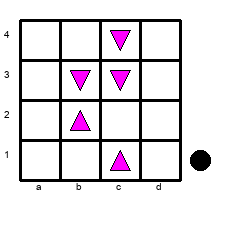

In [ ]:
# @title
# コマ数が 2x2以外でも動くことを確認
state = (1, ((0, 0, -3, 0), (0, -3, -3, 0), (0, 3, 0, 0), (0, 0, 3, 0)))
showstate(state)

# 駒の色が既知としてplayして勝てる時に勝つ戦略
この観点での自分の(手番のプレイヤのではなく)勝ち局面は
- 自分の手番
 - 自分の青駒が脱出ポイントにいる．
 - 自分の駒が相手の唯一の青駒を取れる
 - 自分の駒が相手の青駒(複数枚のうちの一つ)を取った局面が勝ち局面になっている．

負け局面は

- 相手の手番
 - 相手の青駒が脱出ポイントにいる．
 - 相手の駒が自分の唯一の青駒を取れる
 - 相手の駒が自分の青駒(複数枚のうちの一つ)を取った局面が負けち局面になっている．


## 確定5駒以下の後退解析

In [11]:
from collections import Counter
# is_final_det
# values_m1 - value table of states whose pieces are less than the original.
# return value
# 1 : the state is final and player 1 can win
# -1 : the state is final and player 2 can win
# 0 : the state is not final
def is_final_det(state):
    turn, board = state
    H, W = len(state[1]), len(state[1][0])
    mypieces, oppieces =get_pieces(board)
    pcounts = get_pcounts(board)
    if turn == 1:
        if board[0][0] == 1 or board[0][W - 1] == 1: # 脱出できるなら勝ち
            return 1
        for myp in mypieces:
            for p in nextpos(myp, H, W):
                v = board[p[1]][p[0]]
                if v == -1:
                    if pcounts[-1] == 1: # 相手の唯一の青駒を取るのは勝ち
                        return 1
                    newboard = tuple2board(board)
                    newboard[p[1]][p[0]] = board[myp[1]][myp[0]]
                    newboard[myp[1]][myp[0]] = 0
                    newstate = (-turn, board2tuple(newboard))
        return 0
    else:
        if board[H - 1][0] == -1 or board[H - 1][W - 1] == -1: # 相手番で脱出できるようなら負け
            return -1
        for opp in oppieces:
            for p in nextpos(opp,H,W):
                v = board[p[1]][p[0]]
                if v == 1:
                    if pcounts[1] == 1: # 相手の唯一の青駒を取るのは勝ち
                        return -1
                    newboard = tuple2board(board)
                    newboard[p[1]][p[0]] = board[opp[1]][opp[0]]
                    newboard[opp[1]][opp[0]] = 0
                    newstate = (-turn, board2tuple(board))
    return 0




In [ ]:
all_det = states_from_combination(4, 4, mycolorscomb=((1,2), (1,1,2),(1,2,2)),
                                  opcolorscomb=((-1, -2),(-1, -1, -2), (-1, -2, -2)),plimit=5)

results_det = rga(all_det, {s: is_final_det(s) for s in all_det})
save_result(results_det, f'{dir}/results_det.pickle')

In [ ]:
len(all_det)

2184000

## いくつかの結果の確認

True
0


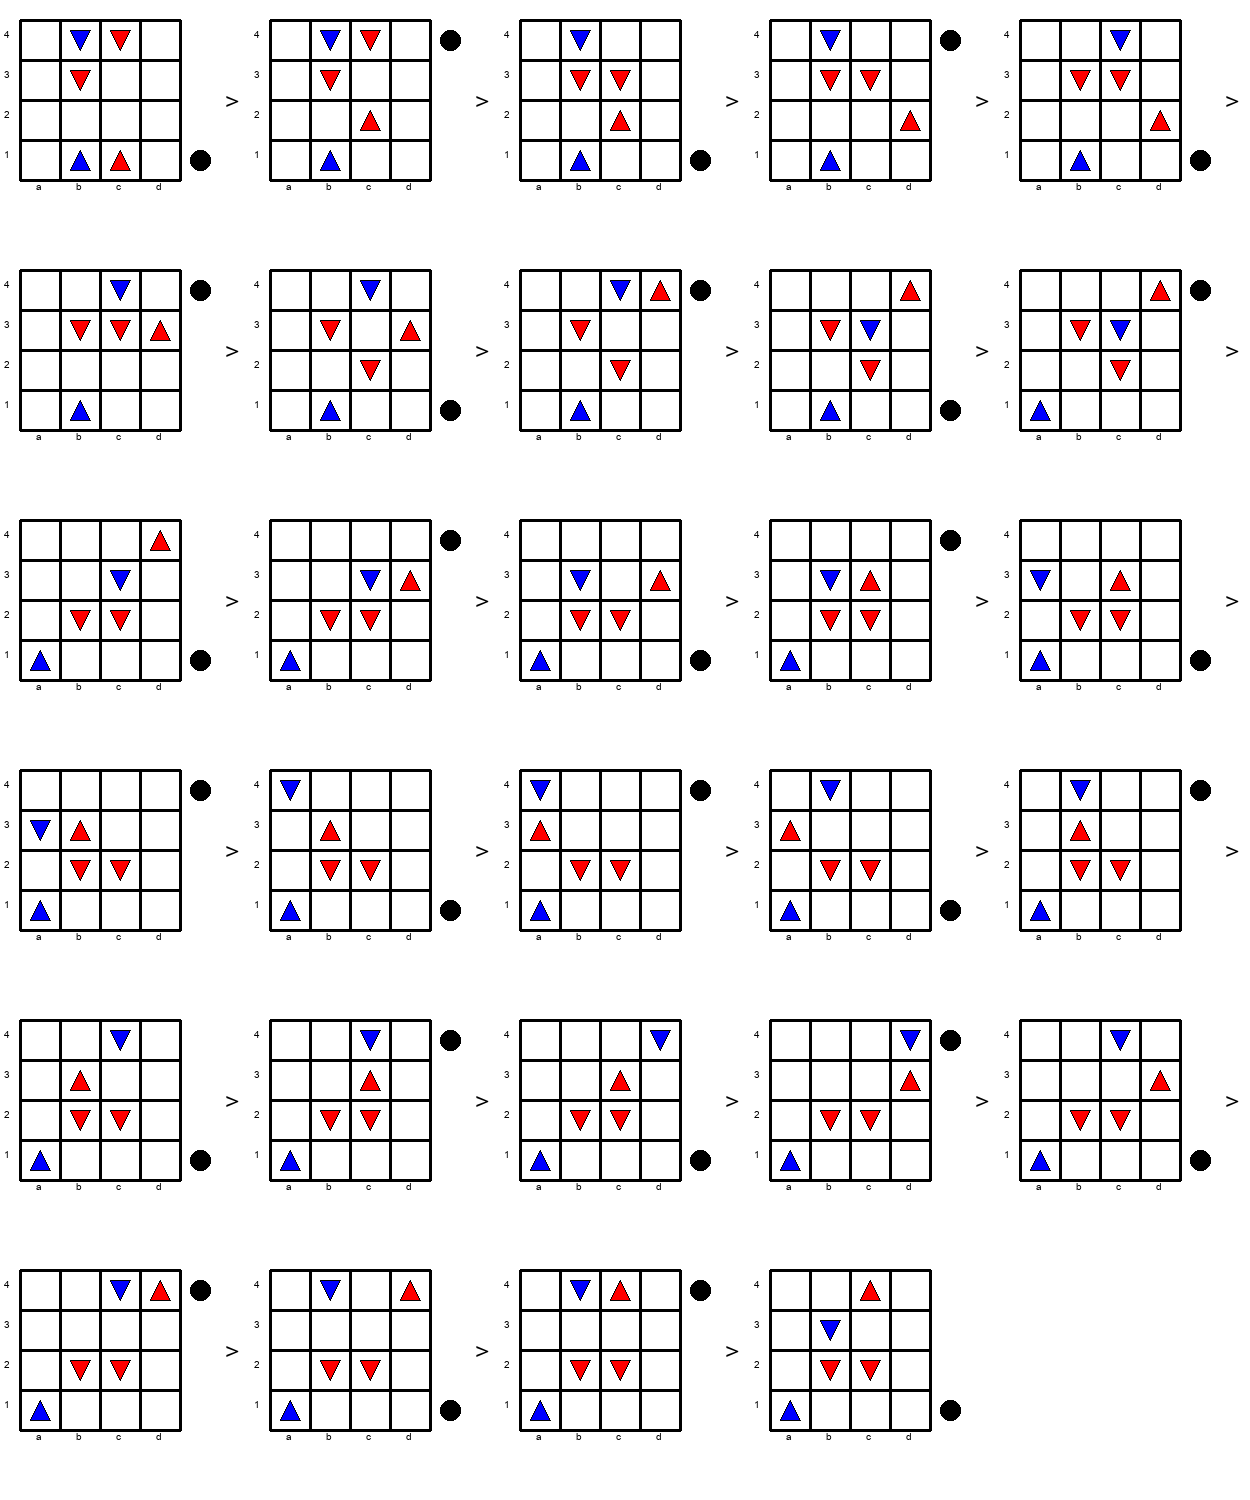

In [ ]:
# @title
s = ((1, ((0, -1, -2, 0), (0, -2, 0, 0), (0, 0, 0, 0), (0, 1, 2, 0))))
print(results_det[0][s])
showstates(one_seq(s, results_det))

-1
[(1, ((0, -1, -2, 0), (0, -1, 0, 0), (0, 0, 0, 0), (0, 1, 2, 0))), (-1, ((0, -1, -2, 0), (0, -1, 0, 0), (0, 0, 0, 0), (1, 0, 2, 0))), (1, ((-1, 0, -2, 0), (0, -1, 0, 0), (0, 0, 0, 0), (1, 0, 2, 0))), (-1, ((-1, 0, -2, 0), (0, -1, 0, 0), (0, 0, 0, 0), (1, 2, 0, 0))), (1, ((0, 0, -2, 0), (-1, -1, 0, 0), (0, 0, 0, 0), (1, 2, 0, 0))), (-1, ((0, 0, -2, 0), (-1, -1, 0, 0), (0, 2, 0, 0), (1, 0, 0, 0))), (1, ((0, 0, -2, 0), (-1, 0, -1, 0), (0, 2, 0, 0), (1, 0, 0, 0))), (-1, ((0, 0, -2, 0), (-1, 0, -1, 0), (0, 0, 2, 0), (1, 0, 0, 0))), (1, ((0, -2, 0, 0), (-1, 0, -1, 0), (0, 0, 2, 0), (1, 0, 0, 0))), (-1, ((0, -2, 0, 0), (-1, 0, -1, 0), (0, 2, 0, 0), (1, 0, 0, 0))), (1, ((0, 0, 0, 0), (-1, -2, -1, 0), (0, 2, 0, 0), (1, 0, 0, 0))), (-1, ((0, 0, 0, 0), (-1, -2, -1, 0), (0, 2, 0, 0), (0, 1, 0, 0))), (1, ((0, 0, 0, 0), (-1, -2, 0, -1), (0, 2, 0, 0), (0, 1, 0, 0))), (-1, ((0, 0, 0, 0), (-1, -2, 0, -1), (0, 0, 2, 0), (0, 1, 0, 0))), (1, ((0, 0, 0, 0), (0, -2, 0, -1), (-1, 0, 2, 0), (0, 1, 0, 0))),

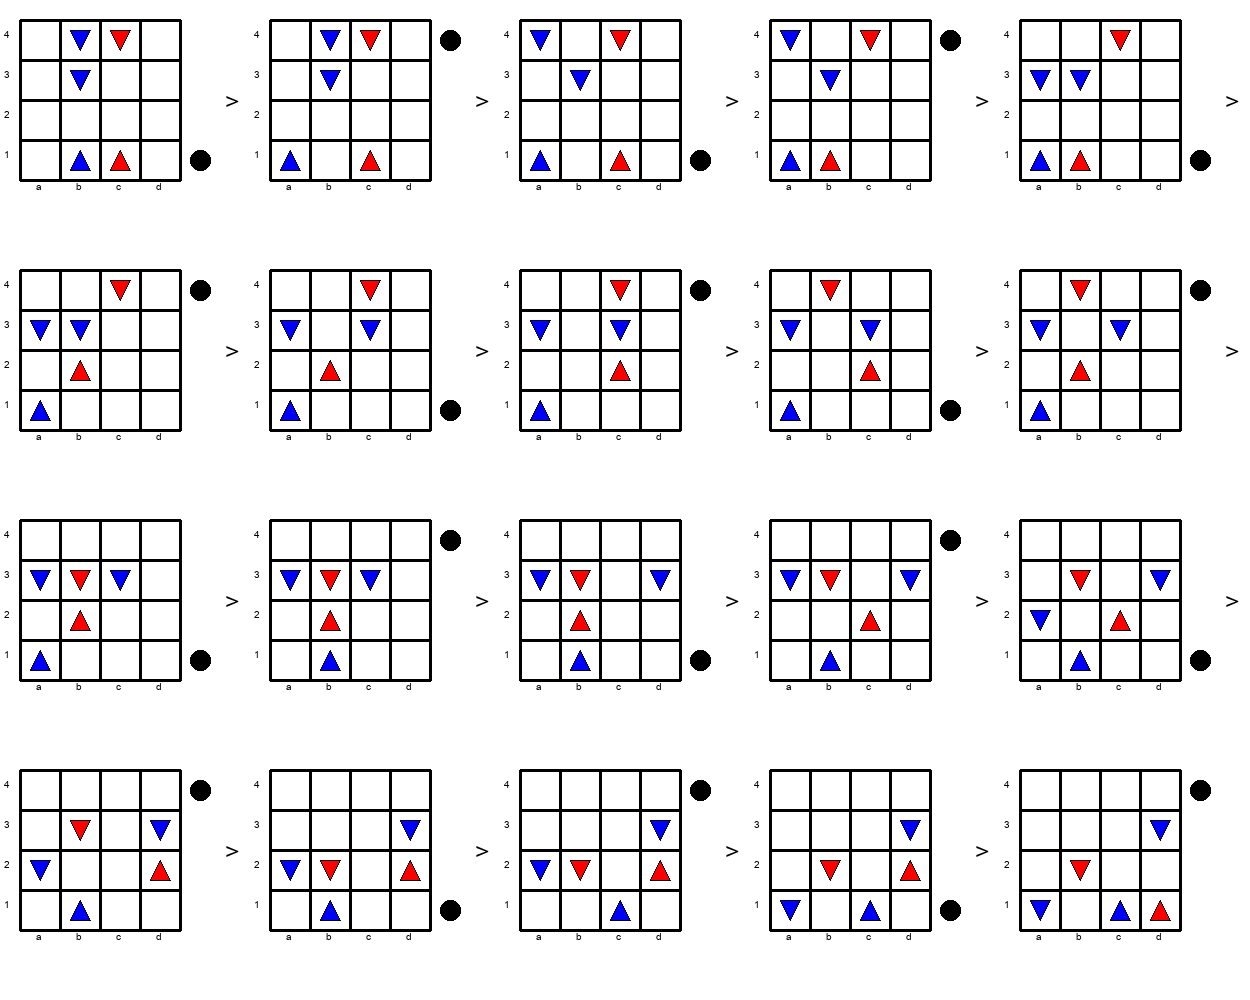

In [ ]:
# @title
s = ((1, ((0, -1, -2, 0), (0, -1, 0, 0), (0, 0, 0, 0), (0, 1, 2, 0))))
print(results_det[0][s])
states = one_seq(s, results_det)
print(states)
showstates(states)

# 自分の駒が既知，相手が紫駒2個でplayして利得1となる戦略
この観点での自分の(手番のプレイヤのではなく)勝ち局面は
- 自分の手番
 - 自分の青駒が脱出ポイントにいる．

負け局面は
- 相手の手番
 - 相手の青駒が脱出ポイントにいる．
 - 相手の駒が自分の唯一の青駒を取れる．

In [ ]:
# is_final_win_det2br
# return value
# 1 : the state is final and player 1 can win
# -1 : the state is final and player 2 can win
# 0 : the state is not final
from collections import Counter
def is_final_win_det2br(state):
    turn, board = state
    H, W = len(state[1]), len(state[1][0])
    mypieces, oppieces = get_pieces(board)
    pcounts = get_pcounts(board)
    #print(f'mypieces={mypieces}, oppieces={oppieces}')
    assert len(oppieces) == 2, f'is_det_final can applicable to only 2x2 games'
    assert pcounts[-3] == 2
    if turn == 1:
        if board[0][0] == 1 or board[0][W - 1] == 1: # can escape
            return 1
    else:
        if board[H - 1][0] == -3 or board[H - 1][W - 1]== -3: # 相手番で脱出できるようなら負け
            return -1
        for opp in oppieces:
            for p in nextpos(opp,H,W):
                v = board[p[1]][p[0]]
                if v == 1:
                    if pcounts[1] == 1: # 自分の唯一の青駒を取られるのは負け
                        return -1
    return 0

In [ ]:
all_det2br = states_from_combination(4, 4, mycolorscomb=((1,2),(1,1,2),(1,2,2)), opcolorscomb=((-3, -3),))
results_win_det2br = rga(all_det2br, {s: is_final_win_det2br(s) for s in all_det2br})
save_result(results_det, f'{dir}/results_win_det2br.pickle')


# いくつかの結果の確認

-1


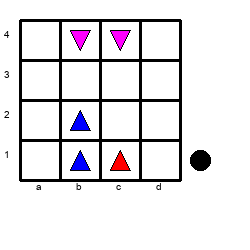

In [ ]:
# @title
s = ((1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 1, 0, 0), (0, 1, 2, 0))))
print(results_win_det2br[0][s])
showstate(s)

1


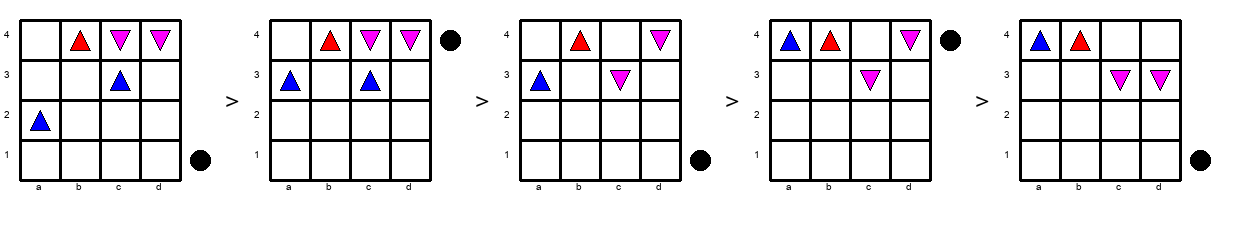

In [ ]:
# @title
s = (1, ((0, 2, -3, -3), (0, 0, 1, 0), (1, 0, 0, 0), (0, 0, 0, 0)))
print(results_win_det2br[0][s])
# showstate(s)
states = one_seq(s, results_win_det2br)
showstates(states)

-1


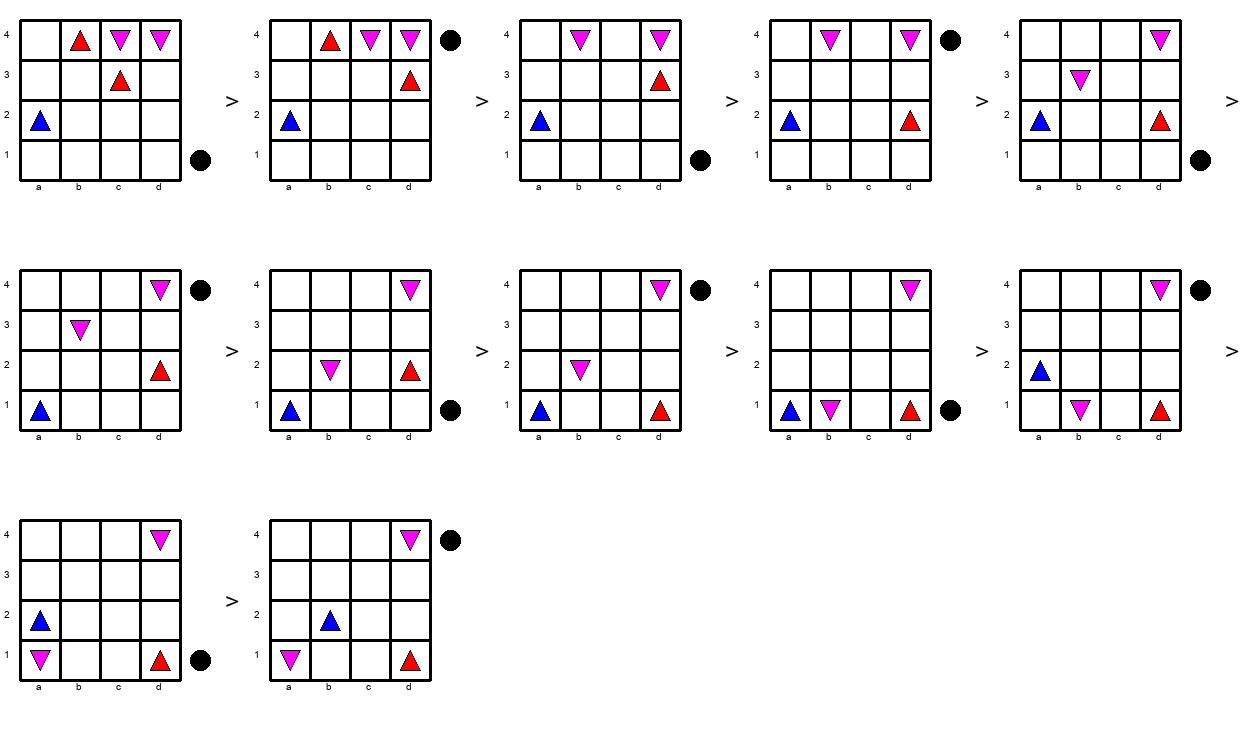

In [ ]:
# @title
s = (1, ((0, 2, -3, -3), (0, 0, 2, 0), (1, 0, 0, 0), (0, 0, 0, 0)))
print(results_win_det2br[0][s])
# showstate(s)
states = one_seq(s, results_win_det2br)
showstates(states)

1
[(1, ((0, 0, 0, 0), (2, 0, 0, 1), (0, -3, -3, 0), (0, 0, 0, 0))), (-1, ((0, 0, 0, 1), (2, 0, 0, 0), (0, -3, -3, 0), (0, 0, 0, 0))), (1, ((0, 0, 0, 1), (2, 0, 0, 0), (0, 0, -3, 0), (0, -3, 0, 0)))]


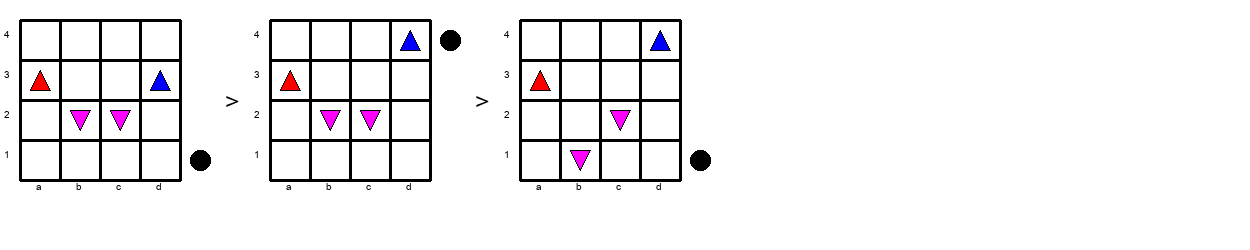

In [ ]:
# @title
s = (1, ((0, 0, 0, 0), (2, 0, 0, 1), (0, -3, -3, 0), (0, 0, 0, 0)))
print(results_win_det2br[0][s])
states = one_seq(s, results_win_det2br)
print(states)
showstates(states)

1
[(1, ((0, 0, 0, 0), (1, 0, 0, 2), (0, -3, -3, 0), (0, 0, 0, 0))), (-1, ((1, 0, 0, 0), (0, 0, 0, 2), (0, -3, -3, 0), (0, 0, 0, 0))), (1, ((1, 0, 0, 0), (0, 0, 0, 2), (0, 0, -3, 0), (0, -3, 0, 0)))]


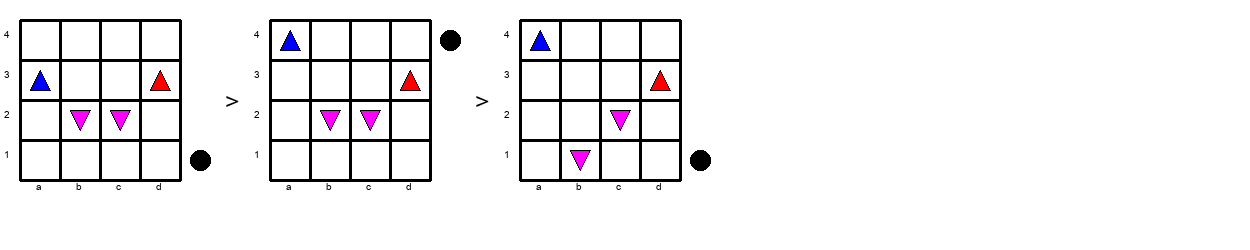

In [ ]:
# @title
s = (1, ((0, 0, 0, 0), (1, 0, 0, 2), (0, -3, -3, 0), (0, 0, 0, 0)))
print(results_win_det2br[0][s])
states = one_seq(s, results_win_det2br)
print(states)
showstates(states)

# det対brでdrawを目指す
自分の駒は 3個以下 (BR, BBR, BRR)
この観点での自分の(手番のプレイヤのではなく)勝ち局面は
- 自分の手番
 - 自分の青駒が脱出ポイントにいる．
 - 相手の駒が青赤，赤青のどちらかと決めると，どちらも勝ち局面
    
負け局面は
- 相手の手番
 - 相手の紫駒が脱出ポイントにいる．
 - 相手が自分の唯一の青駒を取れる


In [19]:
# is_final_draw_det2br
# return value
# 1 : the state is final and player 1 can draw
# -1 : the state is final and player 1 can't draw
# 0 : the state is not final
from collections import Counter
from itertools import permutations
def is_final_draw_det2br(state, results_det):
    turn, board = state
    H, W = len(state[1]), len(state[1][0])
    mypieces, oppieces = get_pieces(board)
    pcounts = get_pcounts(board)
    assert len(mypieces) in (2, 3) and len(oppieces) == 2
    assert pcounts[-3] == 2 and pcounts[3] == 0
    if turn == 1:
        if board[0][0] == 1 or board[0][W - 1] == 1: # can escape
            return 1
        for opps in permutations(oppieces):
            newboard = [list(row) for row in board]
            newboard[opps[0][1]][opps[0][0]] = -1
            newboard[opps[1][1]][opps[1][0]] = -2
            newstate =  (turn, board2tuple(newboard))
            if results_det[0][newstate] != 1:
                return 0
        return 1
    else:
        if board[H - 1][0] == -3 or board[H - 1][W - 1]== -3: # 相手番で脱出できるようなら負け
            return -1
        if pcounts[1] == 1:
            for opp in oppieces:
                for p in nextpos(opp, H, W):
                    if board[p[1]][p[0]] == 1: # can capture my blue
                        return -1
    return 0

In [ ]:
all_det2br = states_from_combination(4, 4, mycolorscomb=((1,2),(1,1,2),(1,2,2)), opcolorscomb=((-3, -3),))
results_draw_det2br = rga(all_det2br, {s: is_final_draw_det2br(s, results_det) for s in all_det2br})
save_result(results_draw_det2br, f'{dir}/results_draw_det2br.pickle')


## 結果の確認

0
[(1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 1, 2, 0))), (-1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 0, 2, 0), (0, 1, 0, 0))), (1, ((0, 0, -3, 0), (0, -3, 0, 0), (0, 0, 2, 0), (0, 1, 0, 0))), (-1, ((0, 0, -3, 0), (0, -3, 2, 0), (0, 0, 0, 0), (0, 1, 0, 0))), (1, ((0, 0, 0, -3), (0, -3, 2, 0), (0, 0, 0, 0), (0, 1, 0, 0))), (-1, ((0, 0, 0, -3), (0, -3, 0, 2), (0, 0, 0, 0), (0, 1, 0, 0))), (1, ((0, 0, -3, 0), (0, -3, 0, 2), (0, 0, 0, 0), (0, 1, 0, 0))), (-1, ((0, 0, -3, 0), (0, -3, 0, 2), (0, 0, 0, 0), (1, 0, 0, 0))), (1, ((0, 0, -3, 0), (0, 0, 0, 2), (0, -3, 0, 0), (1, 0, 0, 0))), (-1, ((0, 0, -3, 0), (0, 0, 2, 0), (0, -3, 0, 0), (1, 0, 0, 0))), (1, ((0, 0, 0, -3), (0, 0, 2, 0), (0, -3, 0, 0), (1, 0, 0, 0))), (-1, ((0, 0, 0, -3), (0, 0, 0, 2), (0, -3, 0, 0), (1, 0, 0, 0)))]


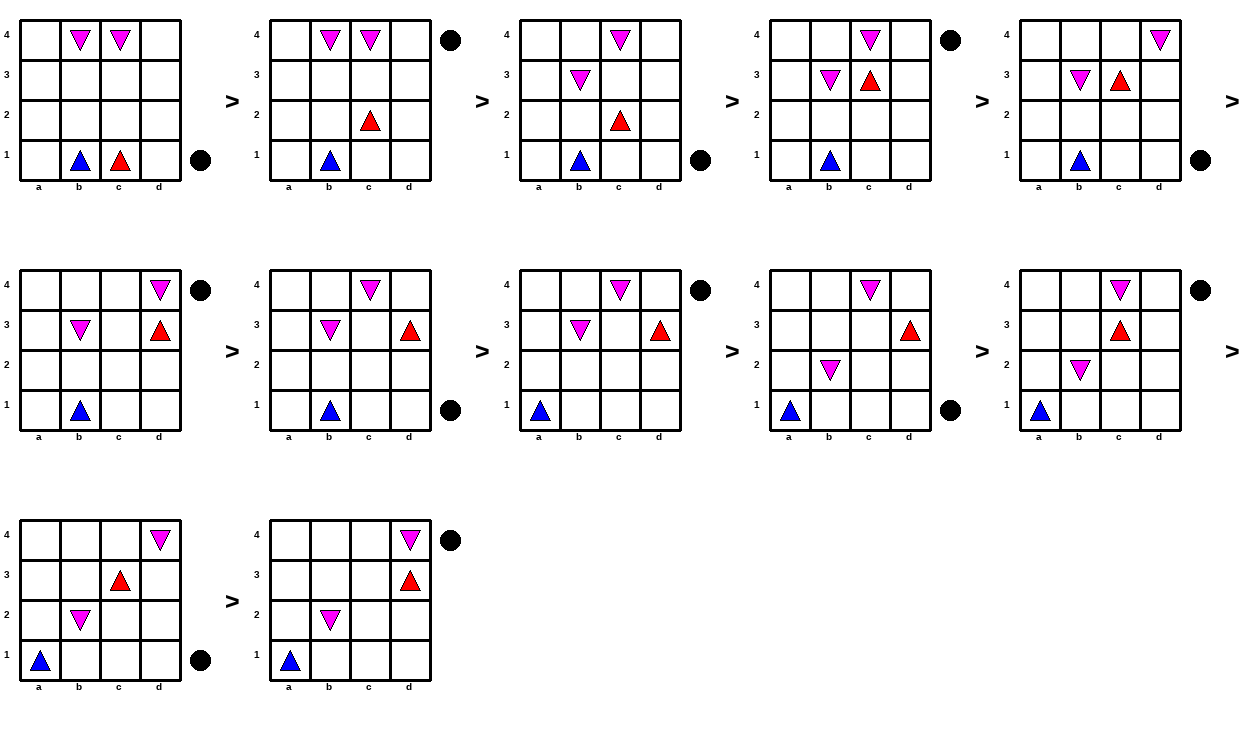

In [20]:
# @title
s = (1,((0, -3, -3, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 1, 2, 0)))
print(results_draw_det2br[0][s])
states = one_seq(s, results_draw_det2br)
print(states)
showstates(states)

-1
[(-1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 1, 2, 0))), (1, ((0, 0, -3, 0), (0, -3, 0, 0), (0, 0, 0, 0), (0, 1, 2, 0))), (-1, ((0, 0, -3, 0), (0, -3, 0, 0), (0, 0, 0, 0), (1, 0, 2, 0))), (1, ((0, 0, -3, 0), (0, 0, 0, 0), (0, -3, 0, 0), (1, 0, 2, 0))), (-1, ((0, 0, -3, 0), (0, 0, 0, 0), (0, -3, 0, 0), (1, 0, 0, 2))), (1, ((0, 0, -3, 0), (0, 0, 0, 0), (0, 0, 0, 0), (1, -3, 0, 2))), (-1, ((0, 0, -3, 0), (0, 0, 0, 0), (1, 0, 0, 0), (0, -3, 0, 2))), (1, ((0, 0, -3, 0), (0, 0, 0, 0), (1, 0, 0, 0), (-3, 0, 0, 2))), (-1, ((0, 0, -3, 0), (0, 0, 0, 0), (0, 1, 0, 0), (-3, 0, 0, 2)))]


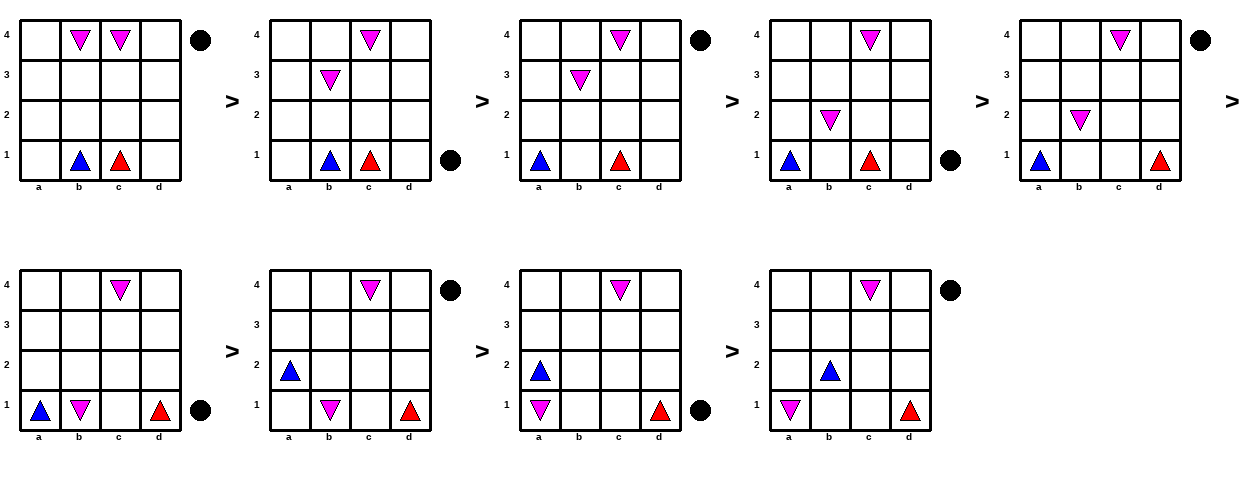

In [21]:
# @title
s = (-1,((0, -3, -3, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 1, 2, 0)))
print(results_draw_det2br[0][s])
states = one_seq(s, results_draw_det2br)
print(states)
showstates(states)

-1
[(1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 2, 0, 0), (0, 1, 2, 0))), (-1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 0, 2, 0), (0, 1, 2, 0))), (1, ((0, 0, -3, 0), (0, -3, 0, 0), (0, 0, 2, 0), (0, 1, 2, 0))), (-1, ((0, 0, -3, 0), (0, -3, 2, 0), (0, 0, 0, 0), (0, 1, 2, 0))), (1, ((0, 0, 0, -3), (0, -3, 2, 0), (0, 0, 0, 0), (0, 1, 2, 0))), (-1, ((0, 0, 0, -3), (0, -3, 0, 2), (0, 0, 0, 0), (0, 1, 2, 0))), (1, ((0, 0, 0, 0), (0, -3, 0, -3), (0, 0, 0, 0), (0, 1, 2, 0))), (-1, ((0, 0, 0, 0), (0, -3, 0, -3), (0, 0, 0, 0), (1, 0, 2, 0))), (1, ((0, 0, 0, 0), (0, 0, 0, -3), (0, -3, 0, 0), (1, 0, 2, 0))), (-1, ((0, 0, 0, 0), (0, 0, 0, -3), (0, -3, 0, 0), (1, 0, 0, 2))), (1, ((0, 0, 0, 0), (0, 0, 0, -3), (-3, 0, 0, 0), (1, 0, 0, 2))), (-1, ((0, 0, 0, 0), (0, 0, 0, -3), (-3, 0, 0, 0), (0, 1, 0, 2))), (1, ((0, 0, 0, 0), (0, 0, 0, -3), (0, 0, 0, 0), (-3, 1, 0, 2))), (-1, ((0, 0, 0, 0), (0, 0, 0, -3), (0, 0, 0, 0), (-3, 0, 1, 2)))]


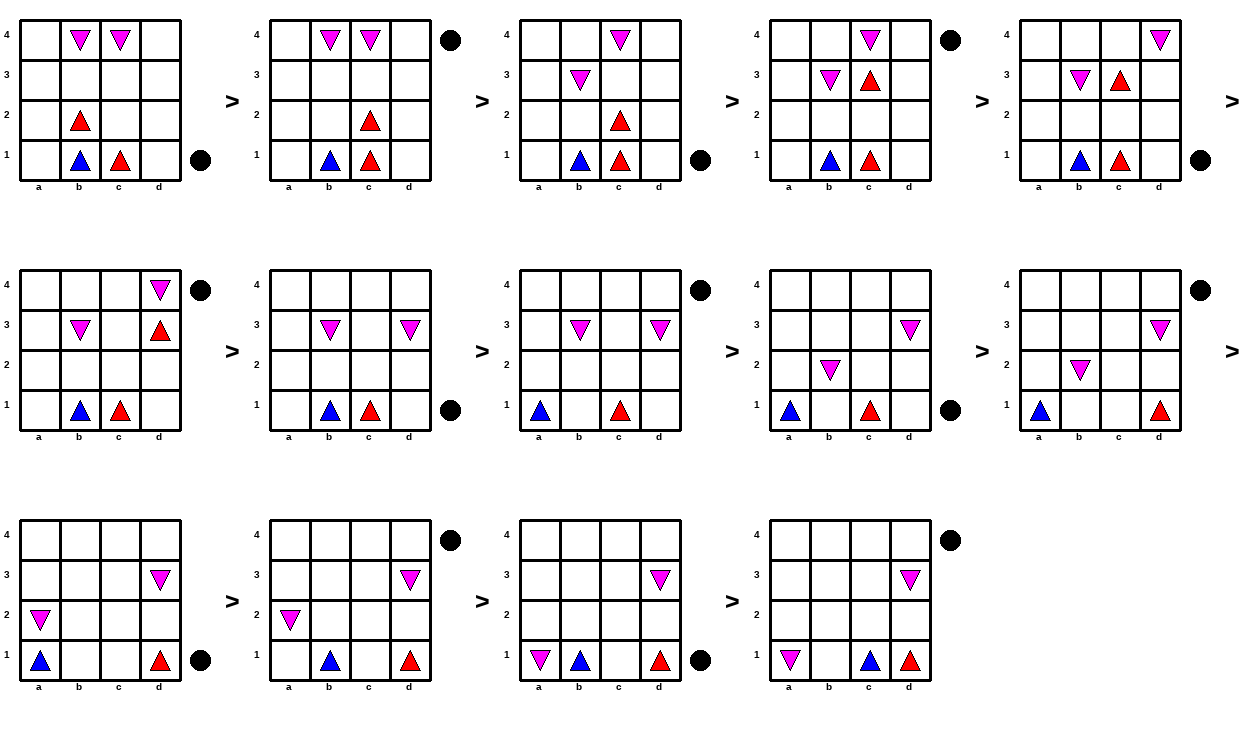

In [22]:
# @title
s = (1,((0, -3, -3, 0), (0, 0, 0, 0), (0, 2, 0, 0), (0, 1, 2, 0)))
print(results_draw_det2br[0][s])
states = one_seq(s, results_draw_det2br)
print(states)
showstates(states)

-1
[(-1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 2, 0, 0), (0, 1, 2, 0))), (1, ((0, 0, -3, 0), (0, -3, 0, 0), (0, 2, 0, 0), (0, 1, 2, 0))), (-1, ((0, 0, -3, 0), (0, -3, 0, 0), (0, 0, 2, 0), (0, 1, 2, 0))), (1, ((0, 0, -3, 0), (0, 0, 0, 0), (0, -3, 2, 0), (0, 1, 2, 0))), (-1, ((0, 0, -3, 0), (0, 0, 0, 0), (0, -3, 2, 0), (1, 0, 2, 0))), (1, ((0, 0, -3, 0), (0, 0, 0, 0), (0, 0, 2, 0), (1, -3, 2, 0))), (-1, ((0, 0, -3, 0), (0, 0, 0, 0), (1, 0, 2, 0), (0, -3, 2, 0))), (1, ((0, 0, -3, 0), (0, 0, 0, 0), (1, 0, 2, 0), (-3, 0, 2, 0))), (-1, ((0, 0, -3, 0), (0, 0, 0, 0), (0, 1, 2, 0), (-3, 0, 2, 0)))]


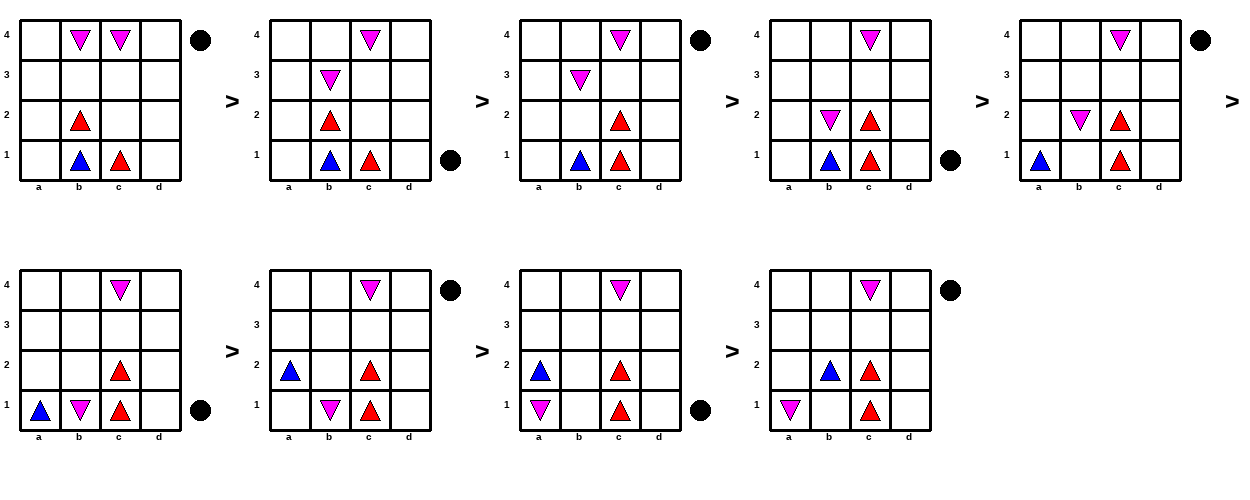

In [23]:
# @title
s = (-1,((0, -3, -3, 0), (0, 0, 0, 0), (0, 2, 0, 0), (0, 1, 2, 0)))
print(results_draw_det2br[0][s])
states = one_seq(s, results_draw_det2br)
print(states)
showstates(states)

1
[(1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 2, 0, 0), (0, 1, 1, 0)))]


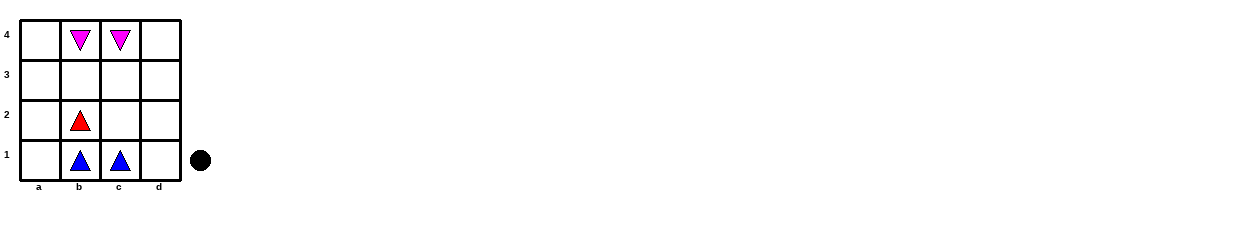

In [24]:
# @title
s = (1,((0, -3, -3, 0), (0, 0, 0, 0), (0, 2, 0, 0), (0, 1, 1, 0)))
print(results_draw_det2br[0][s])
states = one_seq(s, results_draw_det2br)
print(states)
showstates(states)

# 自分の駒が紫2個，相手が紫駒2個でplayして利得0となる戦略(ミニガイスターの解析)

この観点での自分の(手番のプレイヤのではなく)勝ち局面は

- 自分の手番
 - 自分の紫駒が脱出ポイントにいる．
 - 相手の駒の赤青をサイコロで決めて，1/2の確率で当たったら，確実に勝てる．

負け局面は

- 相手の手番
 - 相手の青駒が脱出ポイントにいる．



In [25]:
# is_final_draw_br2br
# return value
# 1 : the state is final and player 1 can draw
# -1 : the state is final and player 1 can't draw
# 0 : the state is not final
from collections import Counter
from itertools import permutations
def is_final_draw_br2br(state, results_win_det2br):
    turn, board = state
    H, W = len(state[1]), len(state[1][0])
    mypieces, oppieces = get_pieces(board)
    pcounts = Counter(board[y][x] for y in range(H) for x in range(W))
    assert len(mypieces) == 2 and len(oppieces) == 2
    assert pcounts[-3] == 2 and pcounts[3] == 2
    for myps in permutations(mypieces):
        newboard = tuple2board(board)
        newboard[myps[0][1]][myps[0][0]] = 1
        newboard[myps[1][1]][myps[1][0]] = 2
        newstate =  (turn, board2tuple(newboard))
        if results_win_det2br[0][newstate] != 1:
                return -1
    return 1


In [ ]:
all_br2br = states_from_combination(4, 4, mycolorscomb=((3,3),), opcolorscomb=((-3, -3),))
results_win_br2br = ({}, {})
for s in all_br2br:
    if is_final_win_br2br(s, results_det) == 1:
        results_win_br2br[0][s] = 1
    else:
        results_win_br2br[0][s] = 0
    results_win_br2br[1][s] = 0
save_result(results_win_br2br, f'{dir}/results_win_br2br.pickle')


-1
[(1, ((0, 0, 0, 0), (3, 0, 0, 3), (0, -3, -3, 0), (0, 0, 0, 0))), (-1, ((0, 0, 0, 0), (0, 0, 0, 3), (3, -3, -3, 0), (0, 0, 0, 0))), (1, ((0, 0, 0, 0), (0, 0, 0, 3), (3, 0, -3, 0), (0, -3, 0, 0))), (-1, ((0, 0, 0, 3), (0, 0, 0, 0), (3, 0, -3, 0), (0, -3, 0, 0))), (1, ((0, 0, 0, 3), (0, 0, 0, 0), (3, 0, 0, -3), (0, -3, 0, 0))), (-1, ((0, 0, 0, 3), (0, 0, 0, 0), (0, 0, 0, -3), (3, -3, 0, 0))), (1, ((0, 0, 0, 3), (0, 0, 0, -3), (0, 0, 0, 0), (3, -3, 0, 0))), (-1, ((0, 0, 3, 0), (0, 0, 0, -3), (0, 0, 0, 0), (3, -3, 0, 0))), (1, ((0, 0, 3, -3), (0, 0, 0, 0), (0, 0, 0, 0), (3, -3, 0, 0))), (-1, ((0, 0, 0, -3), (0, 0, 3, 0), (0, 0, 0, 0), (3, -3, 0, 0))), (1, ((0, 0, 0, 0), (0, 0, 3, -3), (0, 0, 0, 0), (3, -3, 0, 0))), (-1, ((0, 0, 0, 0), (0, 0, 0, -3), (0, 0, 3, 0), (3, -3, 0, 0))), (1, ((0, 0, 0, -3), (0, 0, 0, 0), (0, 0, 3, 0), (3, -3, 0, 0))), (-1, ((0, 0, 0, -3), (0, 0, 0, 0), (0, 0, 0, 3), (3, -3, 0, 0))), (1, ((0, 0, 0, 0), (0, 0, 0, -3), (0, 0, 0, 3), (3, -3, 0, 0))), (-1, ((0, 0, 0

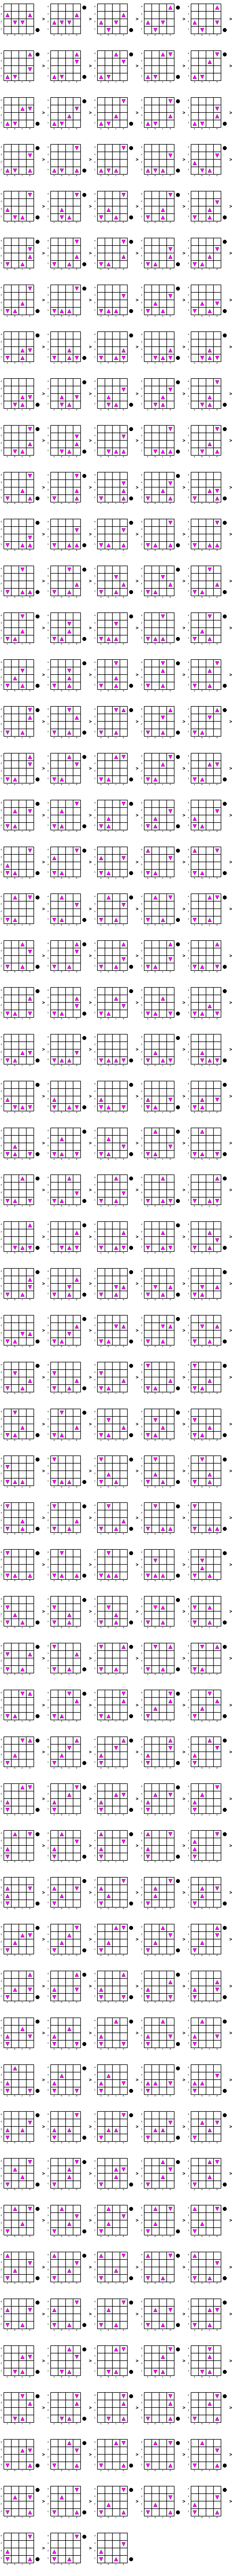

In [28]:
s = (1, ((0, 0, 0, 0), (3, 0, 0, 3), (0, -3, -3, 0), (0, 0, 0, 0)))
print(is_final_draw_br2br(s, results_win_det2br))
states = one_seq(s, results_draw_br2br)
print(states)
showstates(states)

0


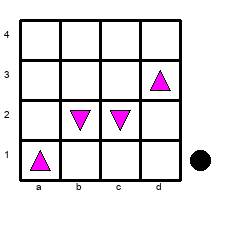

In [ ]:
s = (1, ((0, 0, 0, 0), (0, 0, 0, 3), (0, -3, -3, 0), (3, 0, 0, 0)))
print(results_win_br2br[0][s])
showstate(s)

In [ ]:
# is_final_draw_br2br
# return value
# 1 : the state is final and player 1 can draw
# -1 : the state is final and player 1 can't draw
# 0 : the state is not final
from collections import Counter
from itertools import permutations
def is_final_draw_br2br(state, results_det):
    turn, board = state
    H, W = len(state[1]), len(state[1][0])
    mypieces, oppieces = get_pieces(board)
    pcounts = Counter(board[y][x] for y in range(H) for x in range(W))
    assert len(mypieces) == 2 and len(oppieces) == 2
    assert pcounts[-3] == 2 and pcounts[3] == 2
    if turn == 1:
        if board[0][0] == 3 or board[0][W - 1] == 3: # can escape
            return 1
        for myps in permutations(mypieces):
            for opps in permutations(oppieces):
                newboard = [list(row) for row in board]
                newboard[myps[0][1]][myps[0][0]] = 1
                newboard[myps[1][1]][myps[1][0]] = 2
                newboard[opps[0][1]][opps[0][0]] = -1
                newboard[opps[1][1]][opps[1][0]] = -2
                newstate =  (turn, tuple(tuple(row) for row in newboard))
                if results_det[0][newstate] != 1:
                    return 0
        return 1
    else:
        if board[H - 1][0] == -3 or board[H - 1][W - 1]== -3: # 相手番で脱出できるようなら負け
            return -1
    return 0

1


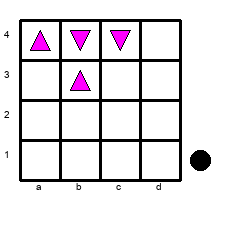

In [ ]:
# チェックする
s = (1, ((3, -3, -3, 0), (0, 3, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0)))
print(is_final_draw_br2br(s, results_det))
showstate(s)

0


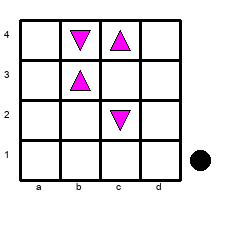

In [ ]:
# チェックする
s = (1, ((0, -3, 3, 0), (0, 3, 0, 0), (0, 0, -3, 0), (0, 0, 0, 0)))
print(is_final_draw_br2br(s, results_det))
showstate(s)

0


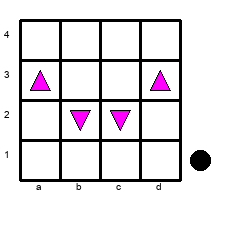

In [ ]:
s = (1, ((0, 0, 0, 0), (3, 0, 0, 3), (0, -3, -3, 0), (0, 0, 0, 0)))
print(results_win_br2br[0][s])
showstate(s)

In [ ]:
all_br2br = states_from_combination(4, 4, mycolorscomb=((3,3),), opcolorscomb=((-3, -3),))
results_draw_br2br = rga(all_br2br, {s: is_final_draw_br2br(s, results_det) for s in all_br2br})
save_result(results_draw_br2br, f'{dir}/results_draw_br2br.pickle')


1
[(1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 3, 3, 0))), (-1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 3, 0, 0), (0, 0, 3, 0))), (1, ((0, 0, -3, 0), (0, -3, 0, 0), (0, 3, 0, 0), (0, 0, 3, 0))), (-1, ((0, 0, -3, 0), (0, -3, 0, 0), (0, 3, 3, 0), (0, 0, 0, 0))), (1, ((0, 0, 0, -3), (0, -3, 0, 0), (0, 3, 3, 0), (0, 0, 0, 0))), (-1, ((0, 0, 0, -3), (0, -3, 0, 0), (0, 3, 0, 3), (0, 0, 0, 0))), (1, ((0, 0, -3, 0), (0, -3, 0, 0), (0, 3, 0, 3), (0, 0, 0, 0))), (-1, ((0, 0, -3, 0), (0, -3, 0, 3), (0, 3, 0, 0), (0, 0, 0, 0))), (1, ((0, -3, 0, 0), (0, -3, 0, 3), (0, 3, 0, 0), (0, 0, 0, 0))), (-1, ((0, -3, 0, 3), (0, -3, 0, 0), (0, 3, 0, 0), (0, 0, 0, 0))), (1, ((0, 0, -3, 3), (0, -3, 0, 0), (0, 3, 0, 0), (0, 0, 0, 0)))]


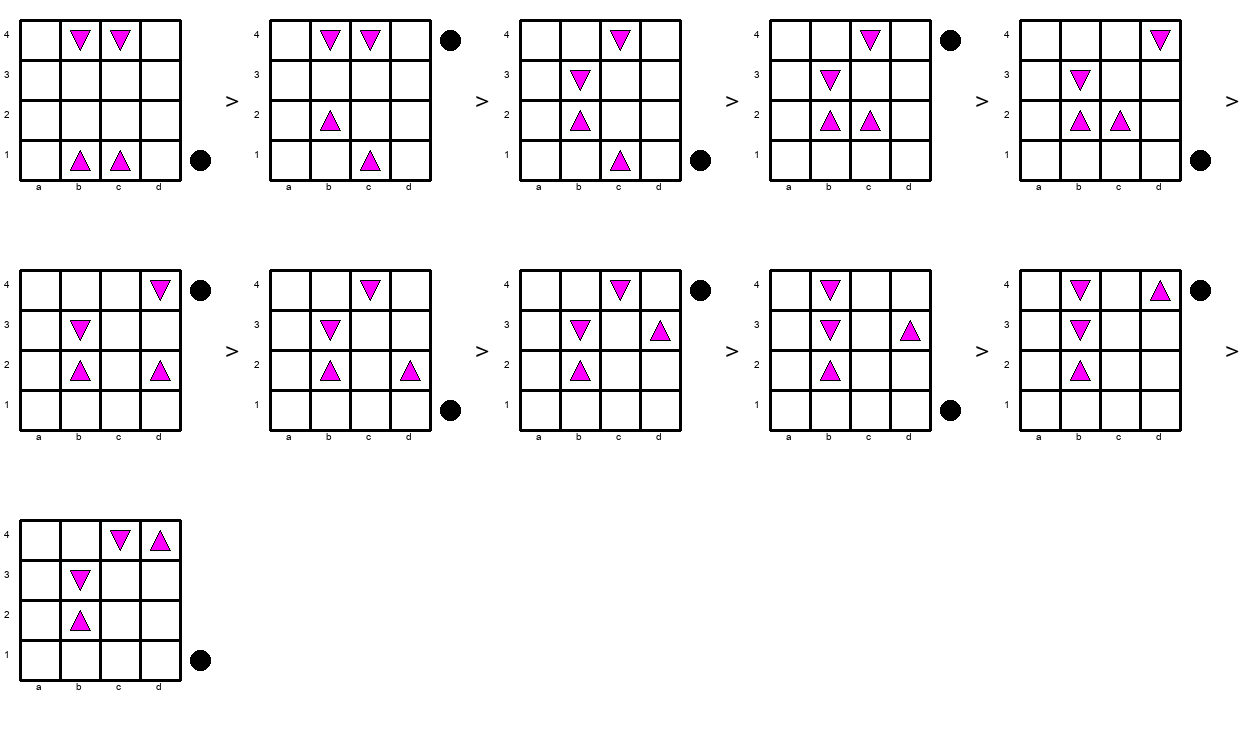

In [ ]:
s = (1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 3, 3, 0)))
print(results_draw_br2br[0][s])
states = one_seq(s, results_draw_br2br)
print(states)
showstates(states)

1
[(-1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 3, 3, 0))), (1, ((0, 0, -3, 0), (0, -3, 0, 0), (0, 0, 0, 0), (0, 3, 3, 0))), (-1, ((0, 0, -3, 0), (0, -3, 0, 0), (0, 3, 0, 0), (0, 0, 3, 0))), (1, ((0, 0, 0, -3), (0, -3, 0, 0), (0, 3, 0, 0), (0, 0, 3, 0))), (-1, ((0, 0, 0, -3), (0, -3, 0, 0), (3, 0, 0, 0), (0, 0, 3, 0))), (1, ((0, 0, 0, -3), (-3, 0, 0, 0), (3, 0, 0, 0), (0, 0, 3, 0))), (-1, ((0, 0, 0, -3), (-3, 0, 0, 0), (3, 0, 0, 0), (0, 0, 0, 3))), (1, ((0, 0, 0, 0), (-3, 0, 0, -3), (3, 0, 0, 0), (0, 0, 0, 3))), (-1, ((0, 0, 0, 0), (-3, 0, 0, -3), (3, 0, 0, 3), (0, 0, 0, 0))), (1, ((-3, 0, 0, 0), (0, 0, 0, -3), (3, 0, 0, 3), (0, 0, 0, 0))), (-1, ((-3, 0, 0, 0), (3, 0, 0, -3), (0, 0, 0, 3), (0, 0, 0, 0))), (1, ((-3, 0, 0, 0), (3, 0, -3, 0), (0, 0, 0, 3), (0, 0, 0, 0))), (-1, ((-3, 0, 0, 0), (3, 0, -3, 3), (0, 0, 0, 0), (0, 0, 0, 0))), (1, ((0, -3, 0, 0), (3, 0, -3, 3), (0, 0, 0, 0), (0, 0, 0, 0))), (-1, ((3, -3, 0, 0), (0, 0, -3, 3), (0, 0, 0, 0), (0, 0, 0, 0))), (1, ((3, 0, -3

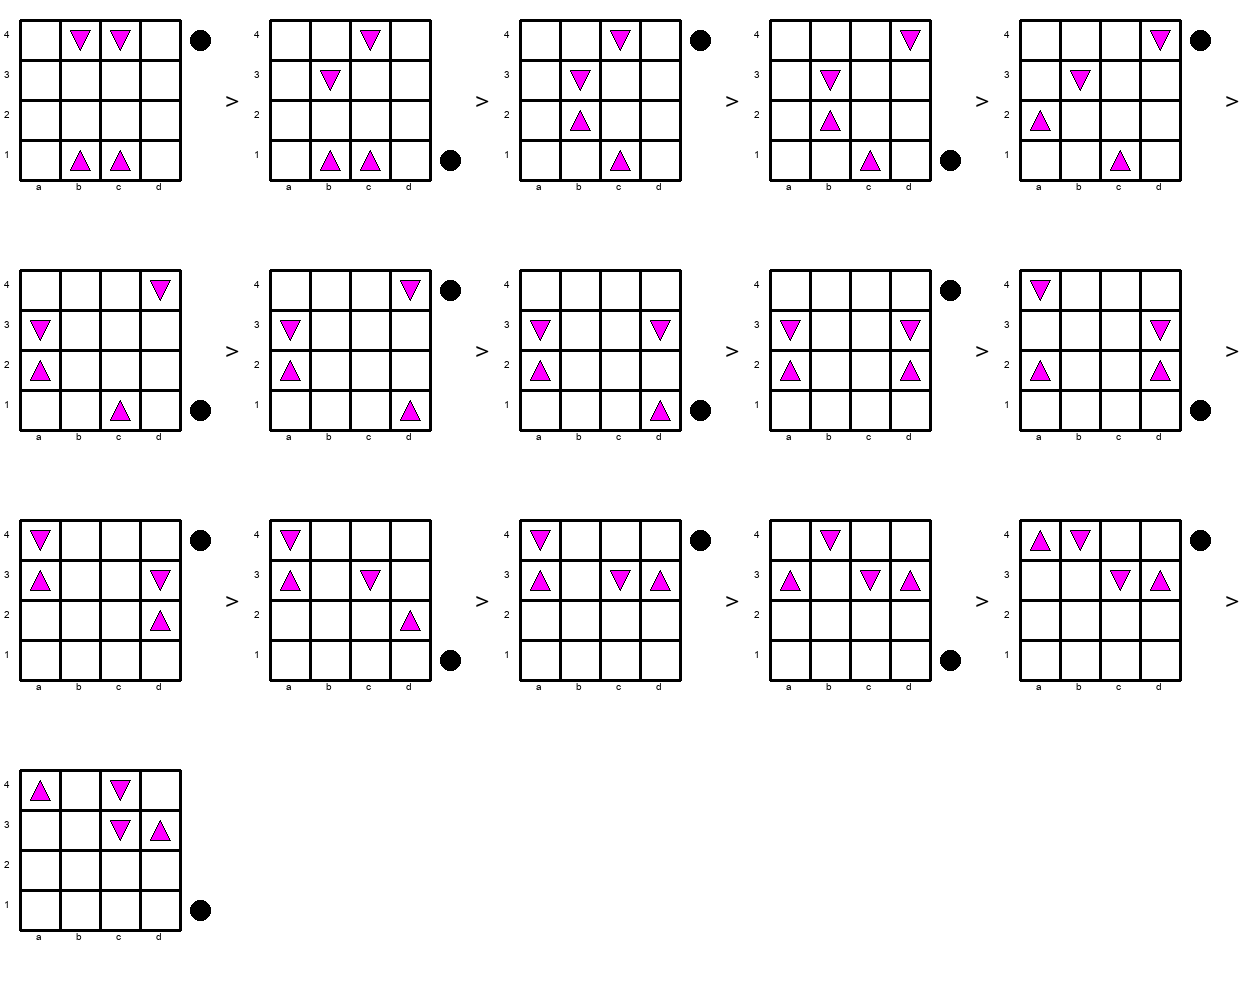

In [ ]:
s = (-1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 3, 3, 0)))
print(results_draw_br2br[0][s])
states = one_seq(s, results_draw_br2br)
print(states)
showstates(states)

プレイヤ1も，プレイヤ2も有限手数で引き分けにできるので，ナッシュ均衡における平均利得は0

In [ ]:
# br対brでwinを目指す

# Bbr対brで利得1/2を目指す

この前にBR対br, BBR対brの引き分け解析が必要

3駒側は青駒を1つ見せて，戦う
この観点での自分の(手番のプレイヤのではなく)勝ち局面は
- 自分の手番
 - 自分の青駒が脱出ポイントにいる．
 - 自分の紫駒が脱出ポイントにいて，それが1/2の確率で赤駒だとしても引き分け
- 相手の手番
 - 自分の駒を取る以外の手がなく，取る手すべてで，それが紫駒の時，1/2の確率青駒だとしても取った後の局面は引き分け, 青駒の時，取った後の局面は自分の勝ち．
    
負け局面は
- 自分の手番
 - 相手の駒を取るしかない (3駒対2駒では現れない)
- 相手の手番
 - 相手の青駒が脱出ポイントにいる．
 - 相手が自分の青駒を取れて，取った後の局面が利得0以下
 - 相手が自分の紫駒を取って，1/2の確率で青となったとき，その後の局面が-1


In [ ]:
# is_final_r05_Bbr2br
# return value
# 1 : the state is final and player 1 can draw
# -1 : the state is final and player 1 can't draw
# 0 : the state is not final
from collections import Counter
from itertools import permutations
def is_final_r05_Bbr2br(state, results_draw_br2br, results_win_br2br, results_draw_det2br):
    turn, board = state
    H, W = len(state[1]), len(state[1][0])
    mypieces, oppieces = get_pieces(board)
    pcounts = get_pcounts(board)
    assert len(mypieces) == 3 and len(oppieces) == 2
    assert pcounts[3] == 2 and pcounts[1] == 1 and pcounts[-3] == 2
    mypurple = [p for p in mypieces if board[p[1]][p[0]] == 3]
    if turn == 1:
        if board[0][0] == 1 or board[0][W - 1] == 1: # can escape
            return 1
        for p in ((0, 0), (W - 1, 0)):
            if board[p[1]][p[0]] == 3:
                i = 0 if p == mypurple[0] else 1
                newboard = tuple2board(board)
                newboard[p[1]][p[0]] = 2
                newboard[mypurple[1 - i][1]][mypurple[1 - i][0]] = 1
                newstate = (turn, board2tuple(newboard))
                if results_draw_det2br[0][newstate] >= 0:
                    return 1
        return 0
    else:
        if board[H - 1][0] == -3 or board[H - 1][W - 1]== -3: # 相手番で脱出できるようなら負け
            return -1
        for opp in oppieces:
            for p in nextpos(opp, H, W):
                if board[p[1]][p[0]] == 1: # can capture my blue
                    newboard = tuple2board(board)
                    newboard[p[1]][p[0]] = -3
                    newboard[opp[1]][opp[0]] = 0
                    newstate = (-turn, board2tuple(newboard))
                    if results_win_br2br[0][newstate] != 1:
                        return -1
                if board[p[1]][p[0]] == 3: # can capture my purple
                    i = 0 if p == mypurple[0] else 1
                    newboard = tuple2board(board)
                    newboard[p[1]][p[0]] = -3
                    newboard[opp[1]][opp[0]] = 0
                    newboard[mypurple[1 - i][1]][mypurple[1 - i][0]] = 2
                    newstate = (turn, board2tuple(newboard))
                    #print(newstate)
                    if results_draw_br2br[0][newstate] < 0:
                        return -1
    return 0

-1


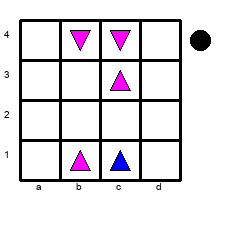

In [ ]:
s = (-1, ((0, -3, -3, 0), (0, 0, 3, 0), (0, 0, 0, 0), (0, 3, 1, 0)))
print(is_final_r05_Bbr2br(s, results_draw_br2br, results_win_br2br, results_draw_det2br))
showstate(s)

In [ ]:
all_Bbr2br = states_from_combination(4, 4, mycolorscomb=((1,3,3),), opcolorscomb=((-3, -3),))
results_r05_Bbr2br = rga(all_Bbr2br, {s: is_final_r05_Bbr2br(s, results_draw_br2br, results_win_br2br, results_draw_det2br) for s in all_Bbr2br})
save_result(results_r05_Bbr2br, f'{dir}/results_r05_Bbr2br.pickle')

-1
[(1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 0, 3, 0), (0, 3, 1, 0))), (-1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 0, 0, 3), (0, 3, 1, 0))), (1, ((0, -3, 0, 0), (0, 0, -3, 0), (0, 0, 0, 3), (0, 3, 1, 0))), (-1, ((0, -3, 0, 0), (0, 0, -3, 0), (0, 0, 0, 3), (0, 3, 0, 1))), (1, ((0, -3, 0, 0), (0, 0, 0, -3), (0, 0, 0, 3), (0, 3, 0, 1))), (-1, ((0, -3, 0, 0), (0, 0, 0, -3), (0, 0, 3, 0), (0, 3, 0, 1))), (1, ((0, -3, 0, 0), (0, 0, 0, 0), (0, 0, 3, -3), (0, 3, 0, 1))), (-1, ((0, -3, 0, 0), (0, 0, 0, 0), (0, 0, 0, -3), (0, 3, 3, 1)))]


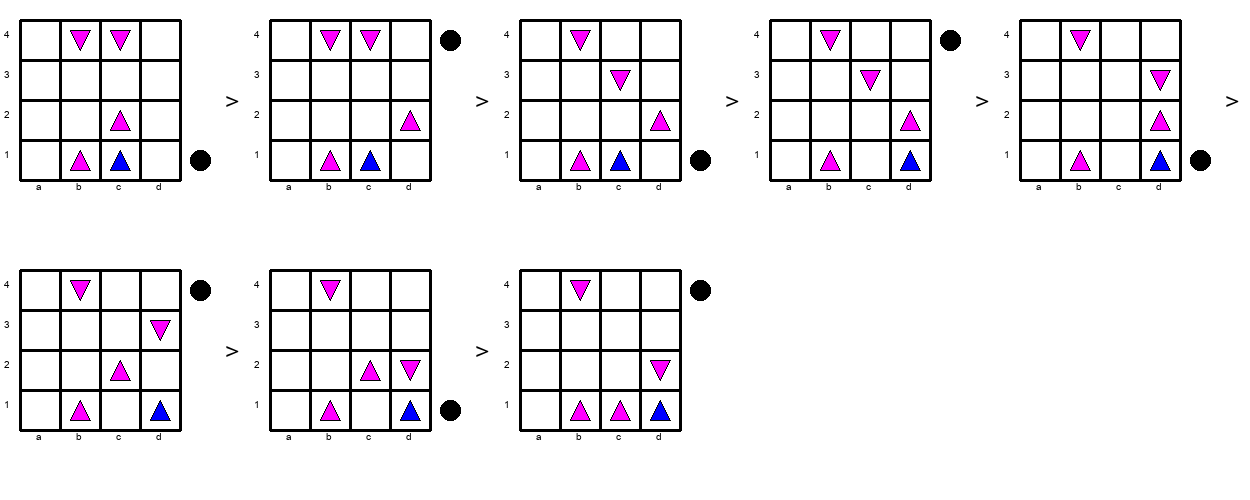

In [ ]:
s = (1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 0, 3, 0), (0, 3, 1, 0)))
print(results_r05_Bbr2br[0][s])
states = one_seq(s, results_r05_Bbr2br)
print(states)
showstates(states)

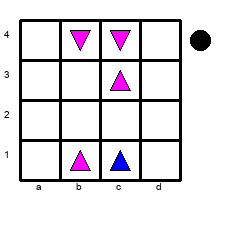

In [ ]:
s = (-1, ((0, -3, -3, 0), (0, 0, 3, 0), (0, 0, 0, 0), (0, 3, 1, 0)))
showstate(s)

-1
[(1, ((0, -3, 0, 0), (0, 0, -3, 0), (0, 0, 0, 0), (0, 2, 1, 0))), (-1, ((0, -3, 0, 0), (0, 0, -3, 0), (0, 0, 0, 0), (2, 0, 1, 0))), (1, ((0, -3, 0, 0), (0, 0, 0, -3), (0, 0, 0, 0), (2, 0, 1, 0))), (-1, ((0, -3, 0, 0), (0, 0, 0, -3), (0, 0, 0, 0), (0, 2, 1, 0))), (1, ((0, -3, 0, 0), (0, 0, 0, 0), (0, 0, 0, -3), (0, 2, 1, 0))), (-1, ((0, -3, 0, 0), (0, 0, 0, 0), (0, 0, 0, -3), (2, 0, 1, 0))), (1, ((0, -3, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (2, 0, 1, -3))), (-1, ((0, -3, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 2, 1, -3)))]


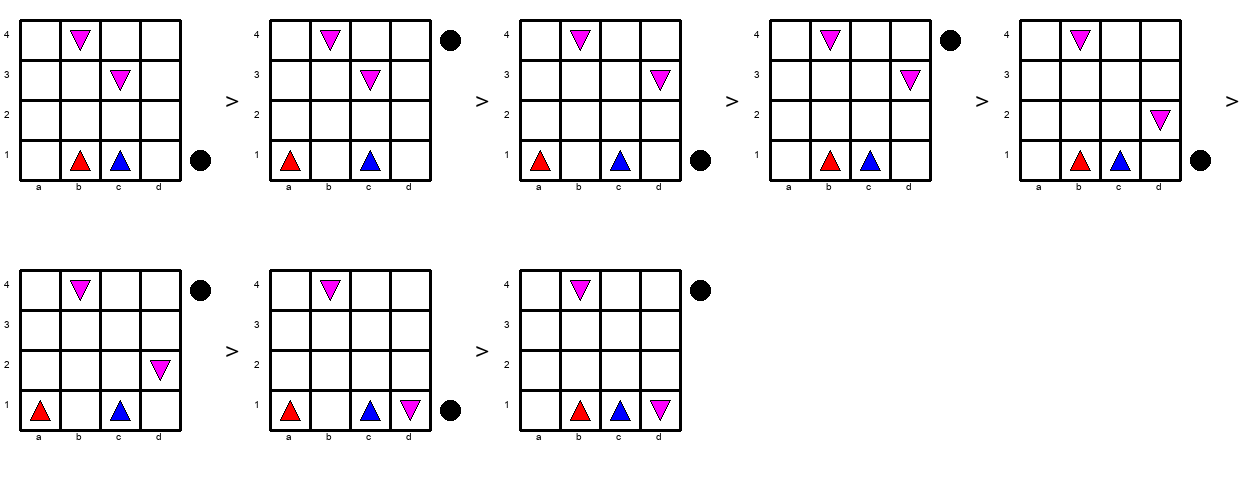

In [ ]:
s = (1, ((0, -3, 0, 0), (0, 0, -3, 0), (0, 0, 0, 0), (0, 2, 1, 0)))
print(results_draw_det2br[0][s])
states = one_seq(s, results_draw_det2br)
print(states)
showstates(states)

この初期配置については利得1/2を達成できない．
## 手番を変更

0
[(-1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 0, 3, 0), (0, 3, 1, 0))), (1, ((0, 0, -3, 0), (0, -3, 0, 0), (0, 0, 3, 0), (0, 3, 1, 0))), (-1, ((0, 0, -3, 0), (0, -3, 0, 0), (0, 3, 3, 0), (0, 0, 1, 0))), (1, ((0, 0, 0, -3), (0, -3, 0, 0), (0, 3, 3, 0), (0, 0, 1, 0))), (-1, ((0, 0, 0, -3), (0, -3, 0, 0), (0, 3, 0, 3), (0, 0, 1, 0))), (1, ((0, 0, 0, -3), (-3, 0, 0, 0), (0, 3, 0, 3), (0, 0, 1, 0))), (-1, ((0, 0, 0, -3), (-3, 0, 0, 0), (3, 0, 0, 3), (0, 0, 1, 0))), (1, ((0, 0, 0, 0), (-3, 0, 0, -3), (3, 0, 0, 3), (0, 0, 1, 0))), (-1, ((0, 0, 0, 0), (-3, 0, 0, -3), (3, 0, 0, 3), (0, 0, 0, 1))), (1, ((0, 0, 0, -3), (-3, 0, 0, 0), (3, 0, 0, 3), (0, 0, 0, 1))), (-1, ((0, 0, 0, -3), (-3, 0, 0, 0), (3, 0, 3, 0), (0, 0, 0, 1))), (1, ((0, 0, 0, 0), (-3, 0, 0, -3), (3, 0, 3, 0), (0, 0, 0, 1))), (-1, ((0, 0, 0, 0), (-3, 0, 0, -3), (3, 0, 3, 1), (0, 0, 0, 0))), (1, ((0, 0, 0, -3), (-3, 0, 0, 0), (3, 0, 3, 1), (0, 0, 0, 0))), (-1, ((0, 0, 0, -3), (-3, 0, 0, 0), (0, 0, 3, 1), (3, 0, 0, 0))), (1, ((0, 0, 0,

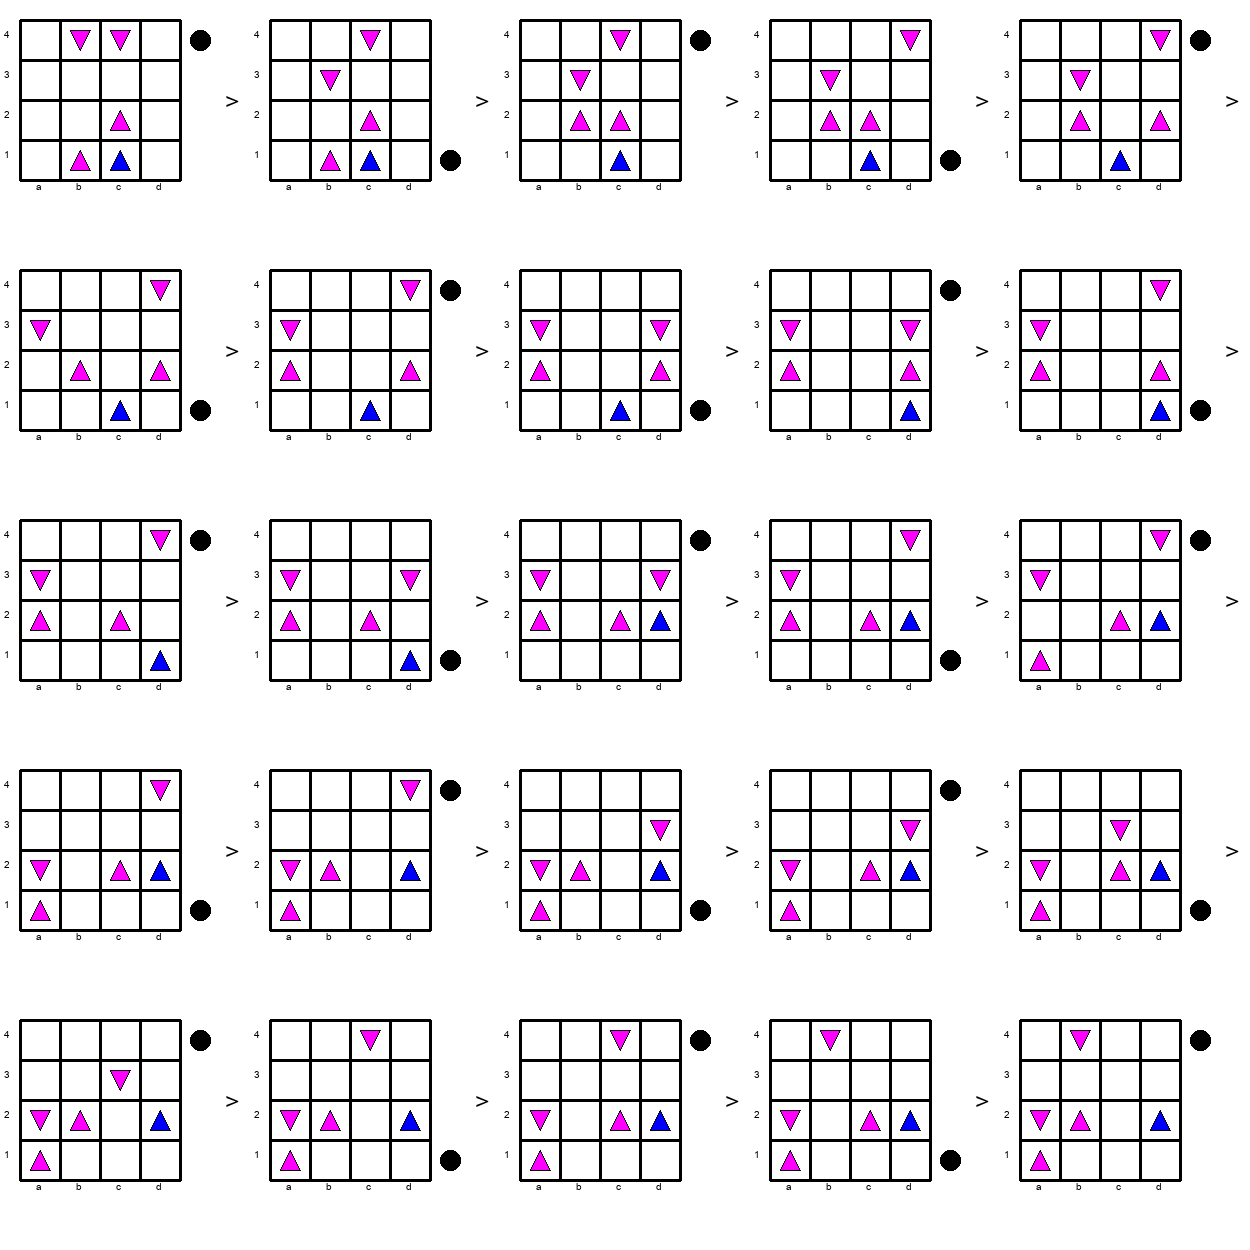

In [ ]:
s = (-1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 0, 3, 0), (0, 3, 1, 0)))
print(results_r05_Bbr2br[0][s])
states = one_seq(s, results_r05_Bbr2br)
print(states)
showstates(states)

こちらはだめ
### 初期配置を横並びに変更

0
[(1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 3, 3, 1))), (-1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 0, 3, 0), (0, 3, 0, 1))), (1, ((0, 0, -3, 0), (0, -3, 0, 0), (0, 0, 3, 0), (0, 3, 0, 1))), (-1, ((0, 0, -3, 0), (0, -3, 0, 0), (0, 3, 3, 0), (0, 0, 0, 1))), (1, ((0, 0, 0, -3), (0, -3, 0, 0), (0, 3, 3, 0), (0, 0, 0, 1))), (-1, ((0, 0, 0, -3), (0, -3, 0, 0), (0, 3, 0, 3), (0, 0, 0, 1))), (1, ((0, 0, 0, -3), (-3, 0, 0, 0), (0, 3, 0, 3), (0, 0, 0, 1))), (-1, ((0, 0, 0, -3), (-3, 0, 0, 0), (3, 0, 0, 3), (0, 0, 0, 1))), (1, ((0, 0, 0, 0), (-3, 0, 0, -3), (3, 0, 0, 3), (0, 0, 0, 1))), (-1, ((0, 0, 0, 0), (-3, 0, 0, -3), (3, 0, 0, 3), (0, 0, 1, 0))), (1, ((-3, 0, 0, 0), (0, 0, 0, -3), (3, 0, 0, 3), (0, 0, 1, 0))), (-1, ((-3, 0, 0, 0), (0, 0, 0, -3), (0, 0, 0, 3), (3, 0, 1, 0))), (1, ((0, 0, 0, 0), (-3, 0, 0, -3), (0, 0, 0, 3), (3, 0, 1, 0)))]


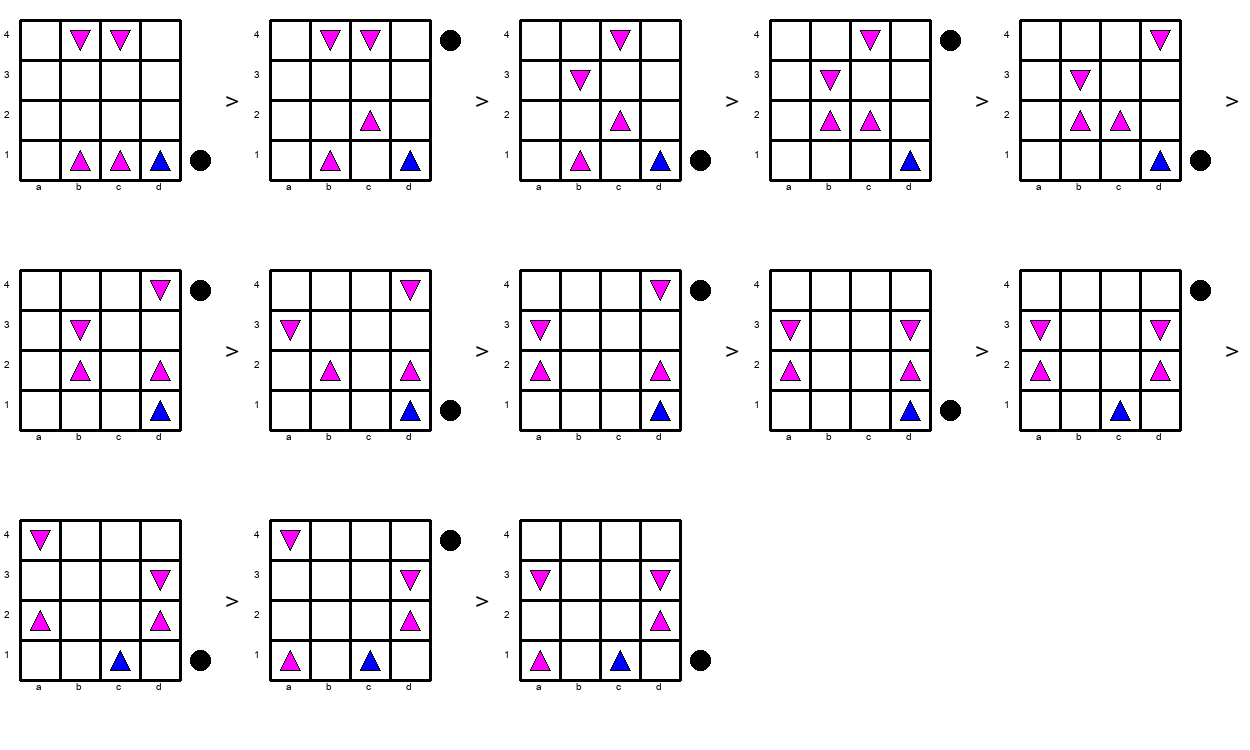

In [ ]:
s = (1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 3, 3, 1)))
print(results_r05_Bbr2br[0][s])
states = one_seq(s, results_r05_Bbr2br)
print(states)
showstates(states)

駄目，他の配置

-1
[(1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 1, 3, 3))), (-1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 0, 3, 0), (0, 1, 0, 3))), (1, ((0, 0, -3, 0), (0, -3, 0, 0), (0, 0, 3, 0), (0, 1, 0, 3))), (-1, ((0, 0, -3, 0), (0, -3, 0, 0), (0, 3, 0, 0), (0, 1, 0, 3))), (1, ((0, 0, 0, 0), (0, -3, -3, 0), (0, 3, 0, 0), (0, 1, 0, 3))), (-1, ((0, 0, 0, 0), (0, -3, -3, 0), (0, 3, 0, 0), (1, 0, 0, 3))), (1, ((0, 0, 0, 0), (-3, 0, -3, 0), (0, 3, 0, 0), (1, 0, 0, 3))), (-1, ((0, 0, 0, 0), (-3, 0, -3, 0), (3, 0, 0, 0), (1, 0, 0, 3))), (1, ((0, 0, 0, 0), (-3, 0, 0, 0), (3, 0, -3, 0), (1, 0, 0, 3))), (-1, ((0, 0, 0, 0), (-3, 0, 0, 0), (3, 0, -3, 0), (1, 0, 3, 0))), (1, ((0, 0, 0, 0), (-3, 0, 0, 0), (3, -3, 0, 0), (1, 0, 3, 0))), (-1, ((0, 0, 0, 0), (-3, 0, 0, 0), (3, -3, 0, 0), (1, 3, 0, 0))), (1, ((0, 0, 0, 0), (0, -3, 0, 0), (3, -3, 0, 0), (1, 3, 0, 0))), (-1, ((0, 0, 0, 0), (3, -3, 0, 0), (0, -3, 0, 0), (1, 3, 0, 0))), (1, ((0, 0, 0, 0), (3, -3, 0, 0), (-3, 0, 0, 0), (1, 3, 0, 0))), (-1, ((3, 0, 0

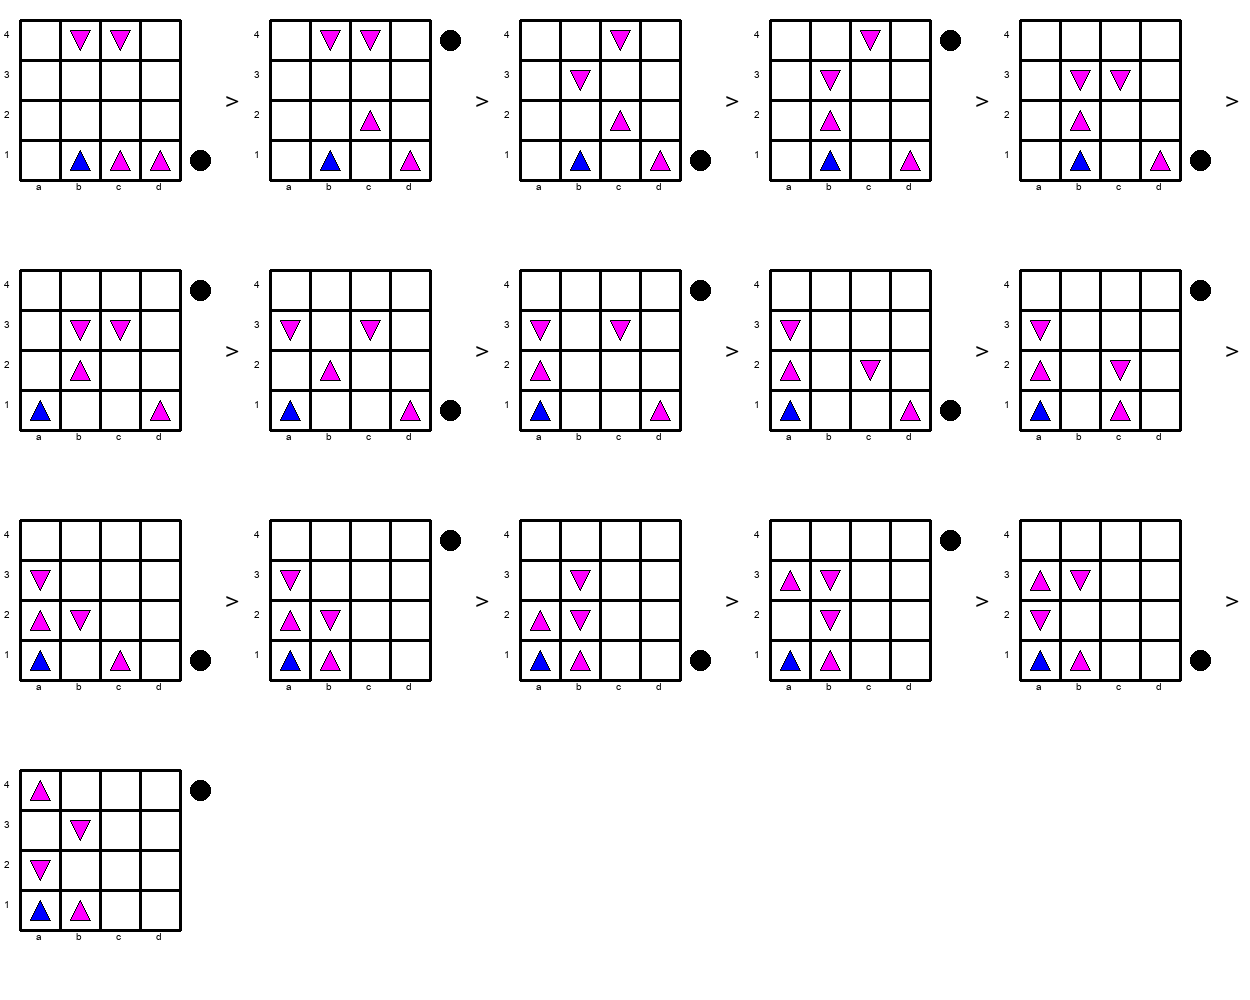

In [ ]:
s = (1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 1, 3, 3)))
print(results_r05_Bbr2br[0][s])
states = one_seq(s, results_r05_Bbr2br)
print(states)
showstates(states)

駄目，他の配置

-1
[(1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 3, 1, 3))), (-1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 0, 0, 3), (0, 3, 1, 0))), (1, ((0, -3, 0, 0), (0, 0, -3, 0), (0, 0, 0, 3), (0, 3, 1, 0))), (-1, ((0, -3, 0, 0), (0, 0, -3, 0), (0, 0, 3, 0), (0, 3, 1, 0))), (1, ((0, -3, 0, 0), (0, -3, 0, 0), (0, 0, 3, 0), (0, 3, 1, 0))), (-1, ((0, -3, 0, 0), (0, -3, 0, 0), (0, 3, 3, 0), (0, 0, 1, 0))), (1, ((-3, 0, 0, 0), (0, -3, 0, 0), (0, 3, 3, 0), (0, 0, 1, 0))), (-1, ((-3, 0, 0, 0), (0, -3, 0, 0), (0, 0, 3, 0), (0, 3, 1, 0))), (1, ((0, 0, 0, 0), (-3, -3, 0, 0), (0, 0, 3, 0), (0, 3, 1, 0))), (-1, ((0, 0, 0, 0), (-3, -3, 0, 0), (0, 3, 0, 0), (0, 3, 1, 0))), (1, ((0, 0, 0, 0), (0, -3, 0, 0), (-3, 3, 0, 0), (0, 3, 1, 0))), (-1, ((0, 0, 0, 0), (0, -3, 0, 0), (-3, 3, 0, 0), (3, 0, 1, 0))), (1, ((0, 0, 0, 0), (0, 0, -3, 0), (-3, 3, 0, 0), (3, 0, 1, 0))), (-1, ((0, 0, 0, 0), (0, 0, -3, 0), (-3, 0, 3, 0), (3, 0, 1, 0))), (1, ((0, 0, 0, 0), (0, 0, 0, -3), (-3, 0, 3, 0), (3, 0, 1, 0))), (-1, ((0, 0, 0

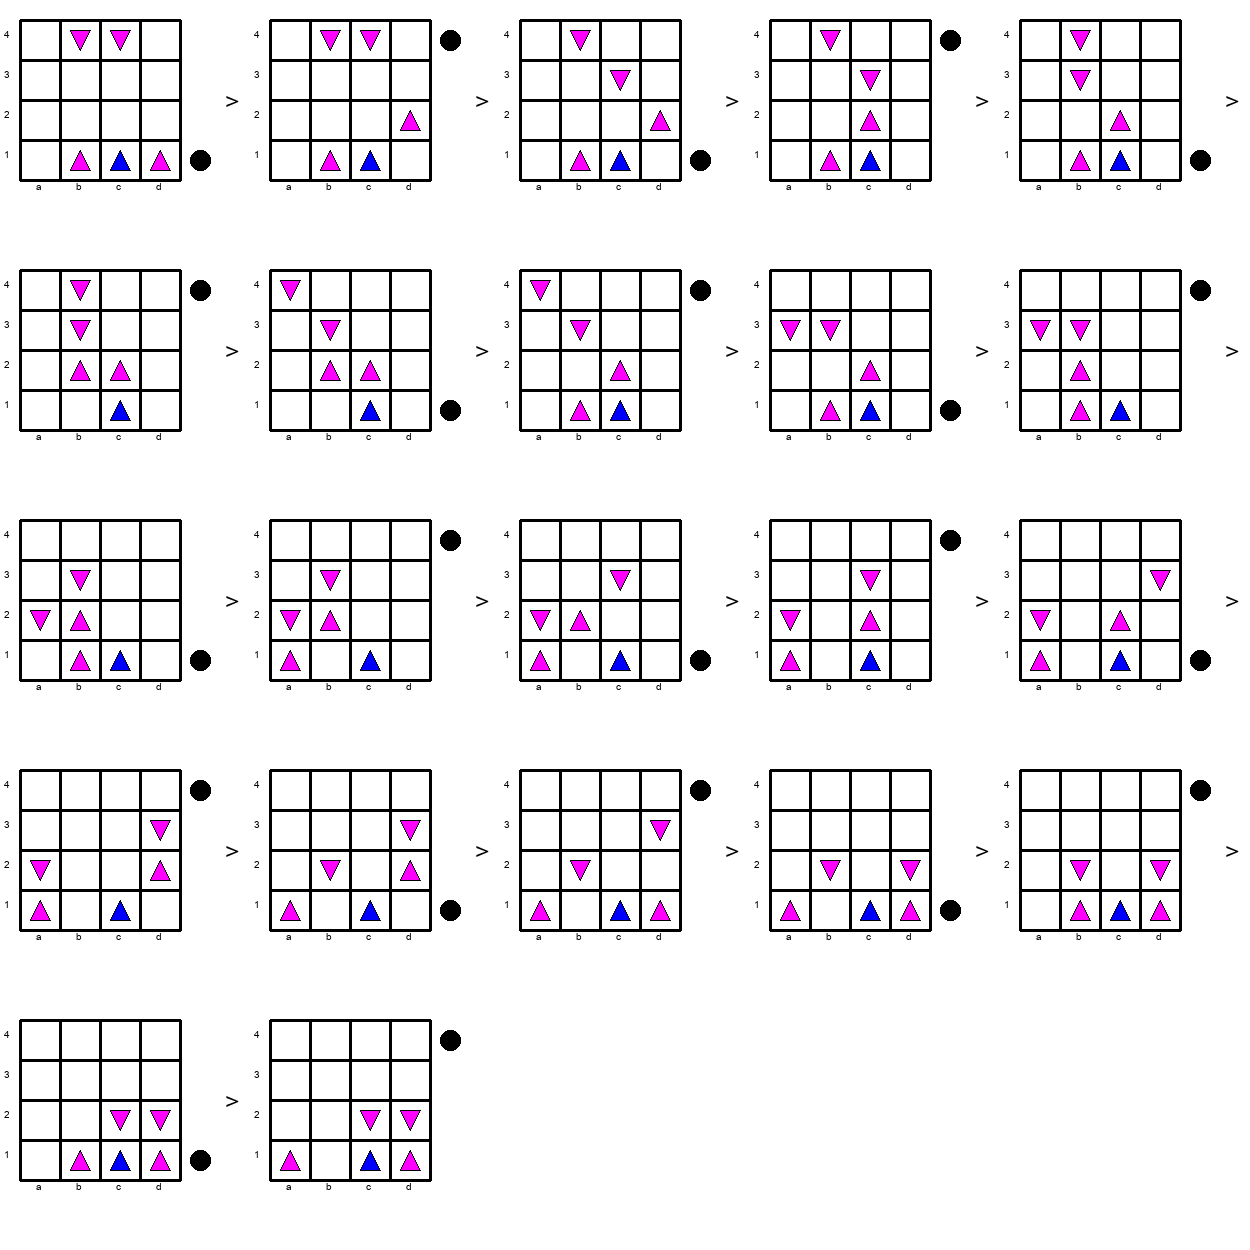

In [ ]:
s = (1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 3, 1, 3)))
print(results_r05_Bbr2br[0][s])
states = one_seq(s, results_r05_Bbr2br)
print(states)
showstates(states)

駄目

# bbr対brで利得1/3を目指す

この観点での自分の(手番のプレイヤのではなく)勝ち局面は
- 自分の手番
 - 自分の紫駒が脱出ポイントにいる．

負け局面は
- 相手の手番
 - 相手の青駒が脱出ポイントにいる．
 - 相手が自分の紫駒を取って，それが利得-1


In [ ]:
# is_final_r03_bbr2br
# return value
# 1 : the state is final and player 1 can draw
# -1 : the state is final and player 1 can't draw
# 0 : the state is not final
from collections import Counter
from itertools import permutations
def is_final_r03_bbr2br(state, results_draw_br2br):
    turn, board = state
    H, W = len(state[1]), len(state[1][0])
    mypieces, oppieces = get_pieces(board)
    pcounts = Counter(board[y][x] for y in range(H) for x in range(W))
    assert len(mypieces) == 3 and len(oppieces) == 2
    assert pcounts[-3] == 2 and pcounts[3] == 3
    if turn == 1:
        if board[0][0] == 3 or board[0][W - 1] == 3: # can escape
            return 1
        return 0
    else:
        if board[H - 1][0] == -3 or board[H - 1][W - 1]== -3: # 相手番で脱出できるようなら負け
            return -1
        for opp in oppieces:
            for p in nextpos(opp,H,W):
                v = board[p[1]][p[0]]
                if v == 3:
                    newboard = [list(row) for row in board]
                    newboard[p[1]][p[0]] = board[opp[1]][opp[0]]
                    newboard[opp[1]][opp[0]] = 0
                    newstate = (-turn, tuple(tuple(row) for row in newboard))
                    if results_draw_br2br[0][newstate] == -1:
                        return -1
    return 0

In [ ]:
all_bbr2br = states_from_combination(4, 4, mycolorscomb=((3,3,3),), opcolorscomb=((-3, -3),))
results_r03_bbr2br = rga(all_bbr2br, {s: is_final_r03_bbr2br(s, results_draw_br2br) for s in all_bbr2br})
save_result(results_r03_bbr2br, f'{dir}/results_r03_bbr2br.pickle')

1
[(1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 0, 3, 0), (0, 3, 3, 0))), (-1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 0, 0, 3), (0, 3, 3, 0))), (1, ((0, 0, -3, 0), (0, -3, 0, 0), (0, 0, 0, 3), (0, 3, 3, 0))), (-1, ((0, 0, -3, 0), (0, -3, 0, 3), (0, 0, 0, 0), (0, 3, 3, 0))), (1, ((0, 0, 0, -3), (0, -3, 0, 3), (0, 0, 0, 0), (0, 3, 3, 0))), (-1, ((0, 0, 0, -3), (0, -3, 0, 3), (0, 3, 0, 0), (0, 0, 3, 0))), (1, ((0, 0, 0, -3), (0, 0, -3, 3), (0, 3, 0, 0), (0, 0, 3, 0))), (-1, ((0, 0, 0, -3), (0, 0, -3, 3), (3, 0, 0, 0), (0, 0, 3, 0))), (1, ((0, 0, 0, -3), (0, 0, 0, 3), (3, 0, -3, 0), (0, 0, 3, 0))), (-1, ((0, 0, 0, -3), (3, 0, 0, 3), (0, 0, -3, 0), (0, 0, 3, 0))), (1, ((0, 0, -3, 0), (3, 0, 0, 3), (0, 0, -3, 0), (0, 0, 3, 0))), (-1, ((3, 0, -3, 0), (0, 0, 0, 3), (0, 0, -3, 0), (0, 0, 3, 0))), (1, ((3, 0, 0, -3), (0, 0, 0, 3), (0, 0, -3, 0), (0, 0, 3, 0)))]


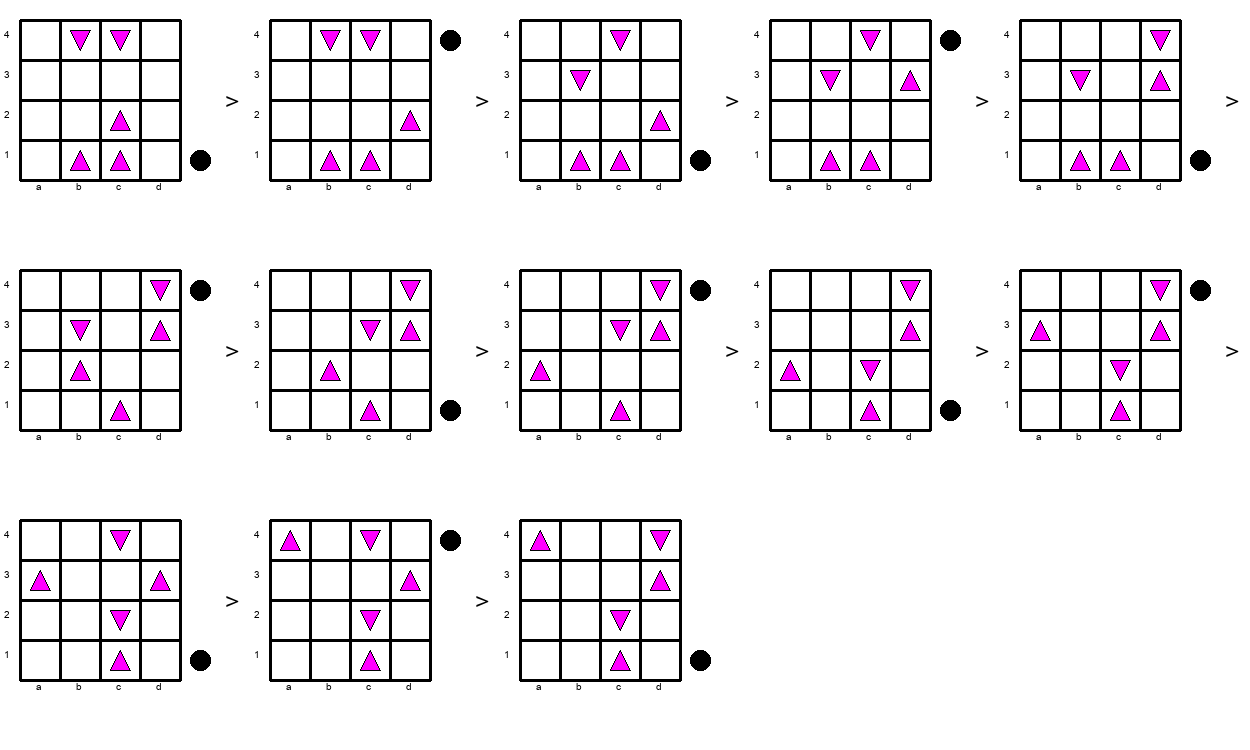

In [ ]:
s = (1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 0, 3, 0), (0, 3, 3, 0)))
print(results_r03_bbr2br[0][s])
states = one_seq(s, results_r03_bbr2br)
print(states)
showstates(states)

[(1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 3, 3, 3))), (-1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 0, 0, 3), (0, 3, 3, 0))), (1, ((0, 0, -3, 0), (0, -3, 0, 0), (0, 0, 0, 3), (0, 3, 3, 0))), (-1, ((0, 0, -3, 0), (0, -3, 0, 3), (0, 0, 0, 0), (0, 3, 3, 0))), (1, ((0, 0, 0, -3), (0, -3, 0, 3), (0, 0, 0, 0), (0, 3, 3, 0))), (-1, ((0, 0, 0, -3), (0, -3, 0, 3), (0, 3, 0, 0), (0, 0, 3, 0))), (1, ((0, 0, 0, -3), (0, 0, -3, 3), (0, 3, 0, 0), (0, 0, 3, 0))), (-1, ((0, 0, 0, -3), (0, 0, -3, 3), (3, 0, 0, 0), (0, 0, 3, 0))), (1, ((0, 0, 0, -3), (0, 0, 0, 3), (3, 0, -3, 0), (0, 0, 3, 0))), (-1, ((0, 0, 0, -3), (3, 0, 0, 3), (0, 0, -3, 0), (0, 0, 3, 0))), (1, ((0, 0, -3, 0), (3, 0, 0, 3), (0, 0, -3, 0), (0, 0, 3, 0))), (-1, ((3, 0, -3, 0), (0, 0, 0, 3), (0, 0, -3, 0), (0, 0, 3, 0))), (1, ((3, 0, 0, -3), (0, 0, 0, 3), (0, 0, -3, 0), (0, 0, 3, 0)))]


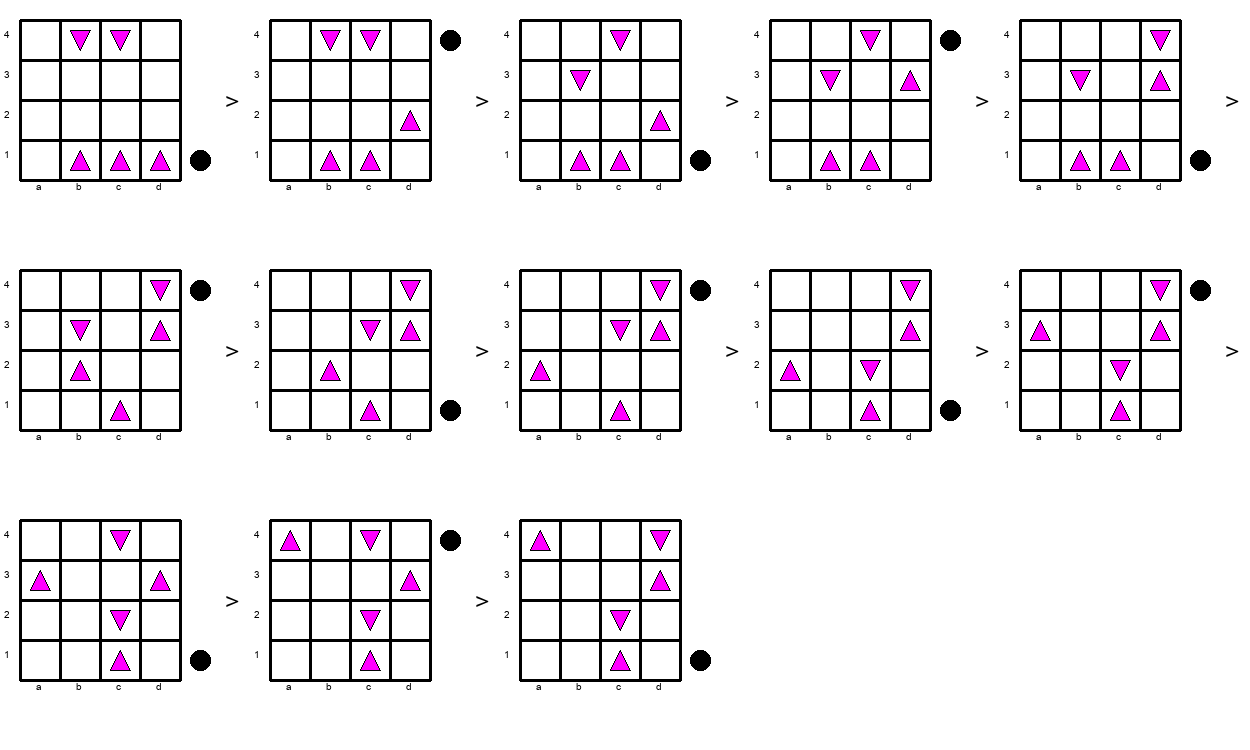

In [ ]:
s = (1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 3, 3, 3)))
states = one_seq(s, results_r03_bbr2br)
print(states)
showstates(states)

-1
[(-1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 3, 3, 3))), (1, ((0, 0, -3, 0), (0, -3, 0, 0), (0, 0, 0, 0), (0, 3, 3, 3))), (-1, ((0, 0, -3, 0), (0, -3, 0, 0), (0, 0, 0, 0), (3, 0, 3, 3))), (1, ((0, 0, -3, 0), (0, 0, 0, 0), (0, -3, 0, 0), (3, 0, 3, 3))), (-1, ((0, 0, -3, 0), (0, 0, 0, 0), (0, -3, 3, 0), (3, 0, 0, 3))), (1, ((0, 0, -3, 0), (0, 0, 0, 0), (0, 0, 3, 0), (3, -3, 0, 3))), (-1, ((0, 0, -3, 0), (0, 0, 0, 0), (3, 0, 3, 0), (0, -3, 0, 3))), (1, ((0, 0, -3, 0), (0, 0, 0, 0), (3, 0, 3, 0), (-3, 0, 0, 3))), (-1, ((0, 0, -3, 0), (0, 0, 0, 0), (0, 3, 3, 0), (-3, 0, 0, 3)))]


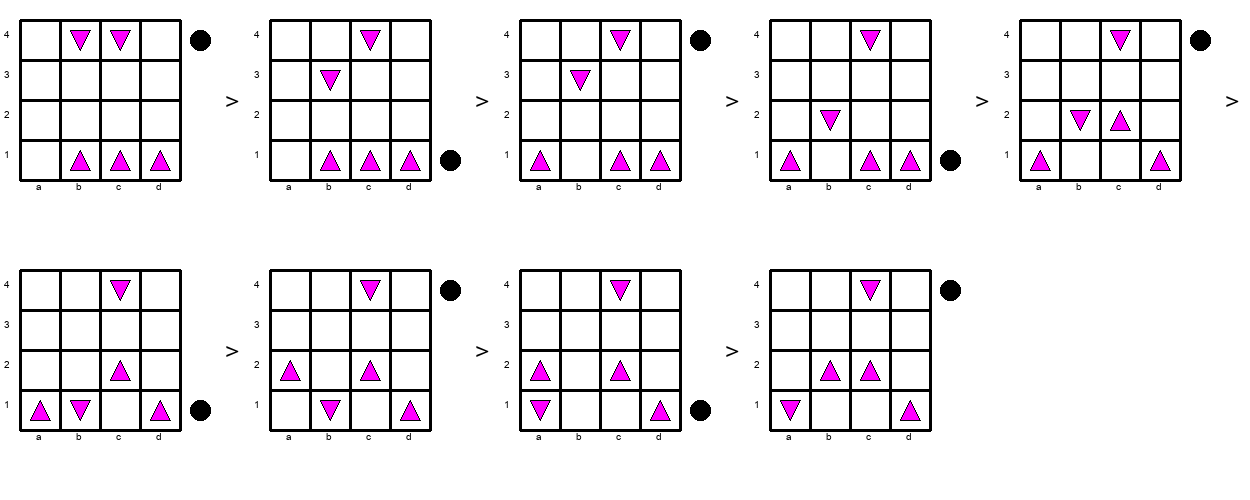

In [ ]:
s = (-1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 3, 3, 3)))
print(results_r03_bbr2br[0][s])
states = one_seq(s, results_r03_bbr2br)
print(states)
showstates(states)

# br対bbrで利得-1/2を目指す

この観点での自分の(手番のプレイヤのではなく)勝ち局面は
- 自分の手番
 - 自分の紫駒が脱出ポイントにいる．
 - 相手の駒を2つ取ることができて，それが青だったときは，br2brでdraw可能なら勝ち配置?

負け局面は
- 相手の手番
 - 相手の紫駒が脱出ポイントにいる．

In [ ]:
# is_final_rm05_br2bbr
# return value
# 1 : the state is final and player 1 can achieve -1/3
# -1 : the state is final and player 1 can't achieve -1/3
# 0 : the state is not final
from collections import Counter
from itertools import permutations
def is_final_rm05_br2bbr(state, results_draw_br2br):
    turn, board = state
    H, W = len(state[1]), len(state[1][0])
    mypieces, oppieces = get_pieces(board)
    pcounts = Counter(board[y][x] for y in range(H) for x in range(W))
    assert len(mypieces) == 2 and len(oppieces) == 3
    assert pcounts[3] == 2 and pcounts[-3] == 3
    if turn == 1:
        if board[0][0] == 3 or board[0][W - 1] == 3: # can escape
            return 1
        drawcount = 0
        for opp in oppieces:
            for nxt in nextpos(opp, H, W):
                if board[nxt[1]][nxt[0]] == 3:
                    newboard = [list(row) for row in board]
                    newboard[opp[1]][opp[0]] = 3
                    newboard[nxt[1]][nxt[0]] = 0
                    newstate =  (-turn, tuple(tuple(row) for row in newboard))
                    if results_draw_br2br[0][newstate] >= 0:
                        drawcount += 1
        if drawcount >= 2:
                return 1
        return 0
    else:
        if board[H - 1][0] == -3 or board[H - 1][W - 1]== -3: # 相手番で脱出できるようなら負け
            return -1
    return 0

In [ ]:
all_br2bbr = states_from_combination(4, 4, mycolorscomb=((3,3),), opcolorscomb=((-3, -3, -3),))
results_rm05_br2bbr = rga(all_br2bbr, {s: is_final_rm05_br2bbr(s, results_det) for s in all_br2bbr})
save_result(results_rm05_br2bbr, f'{dir}/results_rm05_br2bbr.pickle')

1
[(1, ((0, -3, -3, 0), (0, -3, 0, 0), (0, 0, 0, 0), (0, 3, 3, 0))), (-1, ((0, -3, -3, 0), (0, -3, 0, 0), (0, 3, 0, 0), (0, 0, 3, 0))), (1, ((-3, 0, -3, 0), (0, -3, 0, 0), (0, 3, 0, 0), (0, 0, 3, 0))), (-1, ((-3, 0, -3, 0), (0, -3, 0, 0), (0, 3, 3, 0), (0, 0, 0, 0))), (1, ((-3, 0, -3, 0), (0, 0, -3, 0), (0, 3, 3, 0), (0, 0, 0, 0))), (-1, ((-3, 0, -3, 0), (0, 0, -3, 0), (3, 0, 3, 0), (0, 0, 0, 0))), (1, ((-3, 0, 0, -3), (0, 0, -3, 0), (3, 0, 3, 0), (0, 0, 0, 0))), (-1, ((-3, 0, 0, -3), (3, 0, -3, 0), (0, 0, 3, 0), (0, 0, 0, 0))), (1, ((-3, 0, 0, -3), (3, 0, 0, -3), (0, 0, 3, 0), (0, 0, 0, 0))), (-1, ((-3, 0, 0, -3), (3, 0, 0, -3), (0, 0, 0, 3), (0, 0, 0, 0))), (1, ((0, -3, 0, -3), (3, 0, 0, -3), (0, 0, 0, 3), (0, 0, 0, 0))), (-1, ((3, -3, 0, -3), (0, 0, 0, -3), (0, 0, 0, 3), (0, 0, 0, 0))), (1, ((3, 0, -3, -3), (0, 0, 0, -3), (0, 0, 0, 3), (0, 0, 0, 0)))]


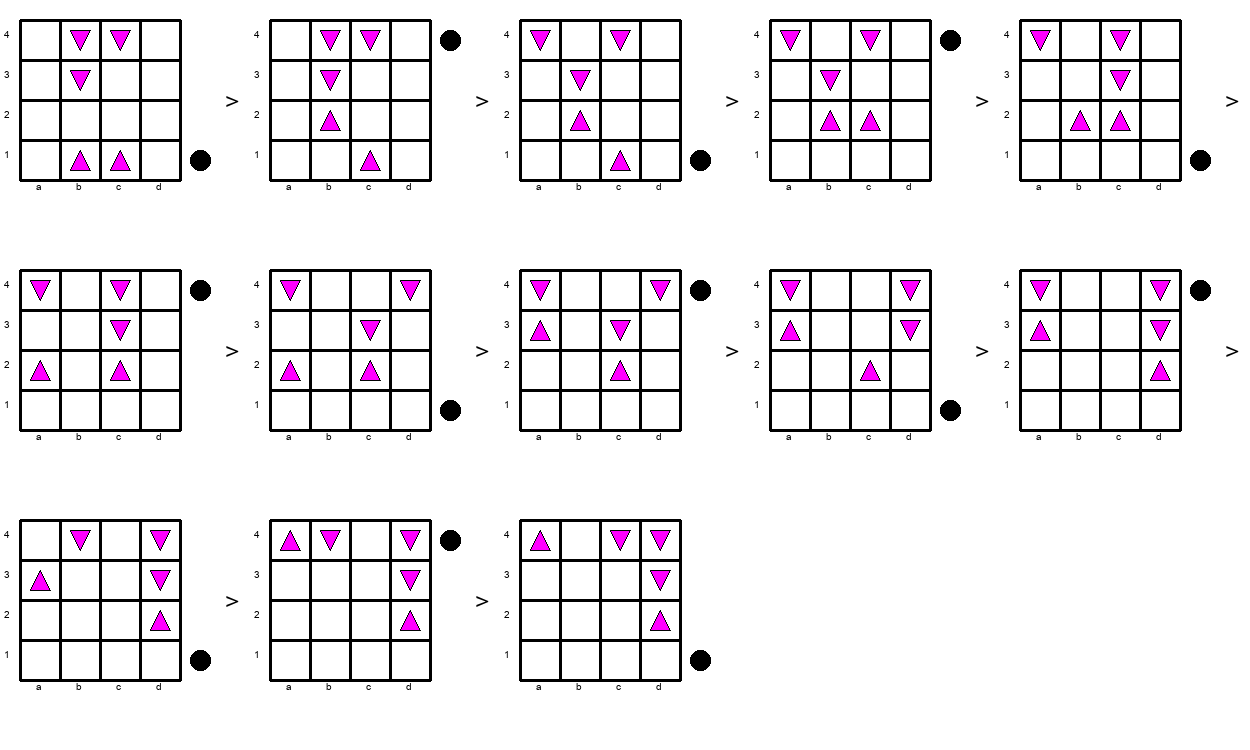

In [ ]:
# 初期配置は?
s = (1, ((0,-3,-3,0),(0,-3,0,0),(0,0,0,0),(0,3,3,0)))
print(results_rm05_br2bbr[0][s])
states = one_seq(s, results_rm05_br2bbr)
print(states)
showstates(states)

手番を変更

1
[(-1, ((0, -3, -3, 0), (0, -3, 0, 0), (0, 0, 0, 0), (0, 3, 3, 0))), (1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, -3, 0, 0), (0, 3, 3, 0))), (-1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, -3, 3, 0), (0, 3, 0, 0))), (1, ((0, -3, -3, 0), (0, 0, 0, 0), (-3, 0, 3, 0), (0, 3, 0, 0))), (-1, ((0, -3, -3, 0), (0, 0, 3, 0), (-3, 0, 0, 0), (0, 3, 0, 0))), (1, ((-3, 0, -3, 0), (0, 0, 3, 0), (-3, 0, 0, 0), (0, 3, 0, 0))), (-1, ((-3, 0, -3, 0), (0, 0, 3, 0), (-3, 0, 0, 0), (3, 0, 0, 0))), (1, ((-3, 0, 0, -3), (0, 0, 3, 0), (-3, 0, 0, 0), (3, 0, 0, 0))), (-1, ((-3, 0, 0, -3), (0, 0, 0, 3), (-3, 0, 0, 0), (3, 0, 0, 0))), (1, ((-3, 0, 0, -3), (0, 0, 0, 3), (0, -3, 0, 0), (3, 0, 0, 0))), (-1, ((-3, 0, 0, -3), (0, 0, 0, 3), (3, -3, 0, 0), (0, 0, 0, 0))), (1, ((-3, 0, 0, -3), (0, 0, 0, 3), (3, 0, -3, 0), (0, 0, 0, 0))), (-1, ((-3, 0, 0, -3), (3, 0, 0, 3), (0, 0, -3, 0), (0, 0, 0, 0))), (1, ((0, -3, 0, -3), (3, 0, 0, 3), (0, 0, -3, 0), (0, 0, 0, 0))), (-1, ((3, -3, 0, -3), (0, 0, 0, 3), (0, 0, -3, 0), (0, 0, 0, 0))),

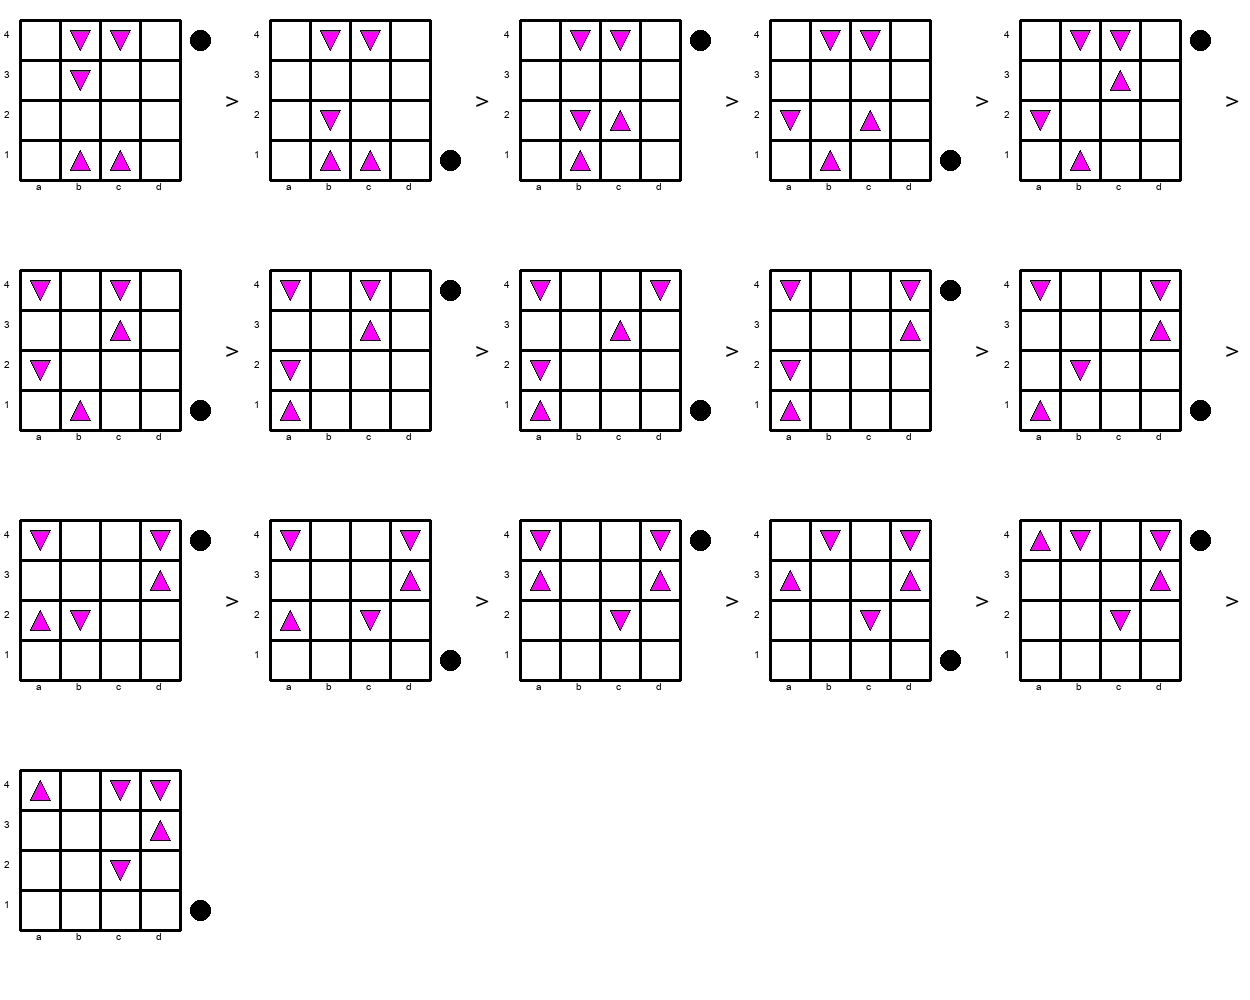

In [ ]:
s = (-1, ((0,-3,-3,0),(0,-3,0,0),(0,0,0,0),(0,3,3,0)))
print(results_rm05_br2bbr[0][s])
states = one_seq(s, results_rm05_br2bbr)
print(states)
showstates(states)

敵の配置を変更

1
[(1, ((-3, -3, -3, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 3, 3, 0))), (-1, ((-3, -3, -3, 0), (0, 0, 0, 0), (0, 3, 0, 0), (0, 0, 3, 0))), (1, ((0, -3, -3, 0), (-3, 0, 0, 0), (0, 3, 0, 0), (0, 0, 3, 0))), (-1, ((0, -3, -3, 0), (-3, 0, 0, 0), (3, 0, 0, 0), (0, 0, 3, 0))), (1, ((0, 0, -3, 0), (-3, -3, 0, 0), (3, 0, 0, 0), (0, 0, 3, 0))), (-1, ((0, 0, -3, 0), (-3, -3, 0, 0), (3, 0, 3, 0), (0, 0, 0, 0))), (1, ((0, 0, 0, -3), (-3, -3, 0, 0), (3, 0, 3, 0), (0, 0, 0, 0))), (-1, ((0, 0, 0, -3), (-3, -3, 3, 0), (3, 0, 0, 0), (0, 0, 0, 0))), (1, ((-3, 0, 0, -3), (0, -3, 3, 0), (3, 0, 0, 0), (0, 0, 0, 0))), (-1, ((-3, 0, 3, -3), (0, -3, 0, 0), (3, 0, 0, 0), (0, 0, 0, 0))), (1, ((-3, 0, 3, 0), (0, -3, 0, -3), (3, 0, 0, 0), (0, 0, 0, 0))), (-1, ((-3, 0, 0, 3), (0, -3, 0, -3), (3, 0, 0, 0), (0, 0, 0, 0))), (1, ((0, -3, 0, 3), (0, -3, 0, -3), (3, 0, 0, 0), (0, 0, 0, 0)))]


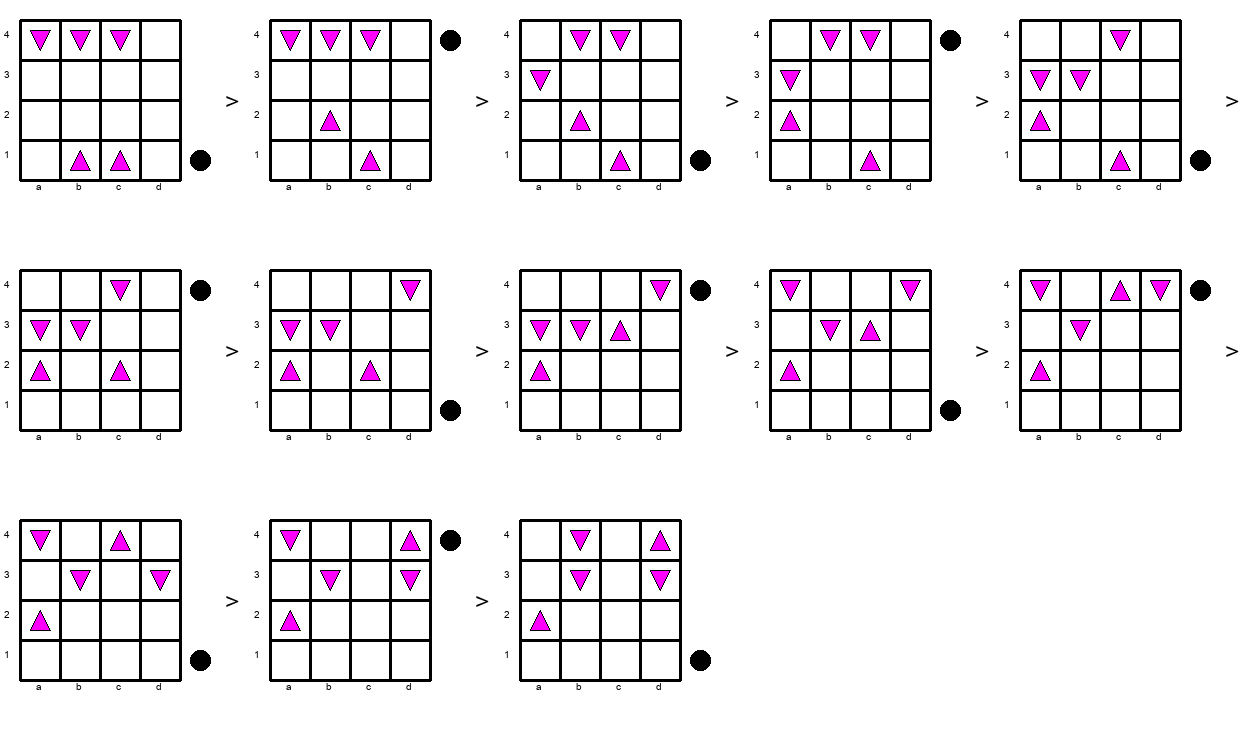

In [ ]:
# 初期配置は?
s = (1, ((-3,-3,-3,0),(0,0,0,0),(0,0,0,0),(0,3,3,0)))
print(results_rm05_br2bbr[0][s])
states = one_seq(s, results_rm05_br2bbr)
print(states)
showstates(states)

1
[(-1, ((-3, -3, -3, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 3, 3, 0))), (1, ((0, -3, -3, 0), (-3, 0, 0, 0), (0, 0, 0, 0), (0, 3, 3, 0))), (-1, ((0, -3, -3, 0), (-3, 0, 0, 0), (0, 0, 0, 0), (3, 0, 3, 0))), (1, ((0, -3, -3, 0), (0, -3, 0, 0), (0, 0, 0, 0), (3, 0, 3, 0))), (-1, ((0, -3, -3, 0), (0, -3, 0, 0), (3, 0, 0, 0), (0, 0, 3, 0))), (1, ((0, -3, -3, 0), (0, 0, 0, 0), (3, -3, 0, 0), (0, 0, 3, 0))), (-1, ((0, -3, -3, 0), (3, 0, 0, 0), (0, -3, 0, 0), (0, 0, 3, 0))), (1, ((-3, 0, -3, 0), (3, 0, 0, 0), (0, -3, 0, 0), (0, 0, 3, 0))), (-1, ((-3, 0, -3, 0), (3, 0, 0, 0), (0, -3, 3, 0), (0, 0, 0, 0))), (1, ((-3, 0, -3, 0), (3, 0, 0, 0), (0, 0, 3, 0), (0, -3, 0, 0))), (-1, ((-3, 0, -3, 0), (3, 0, 3, 0), (0, 0, 0, 0), (0, -3, 0, 0))), (1, ((-3, 0, 0, -3), (3, 0, 3, 0), (0, 0, 0, 0), (0, -3, 0, 0))), (-1, ((-3, 0, 0, -3), (3, 0, 0, 3), (0, 0, 0, 0), (0, -3, 0, 0))), (1, ((0, -3, 0, -3), (3, 0, 0, 3), (0, 0, 0, 0), (0, -3, 0, 0))), (-1, ((3, -3, 0, -3), (0, 0, 0, 3), (0, 0, 0, 0), (0, -3, 0, 0))),

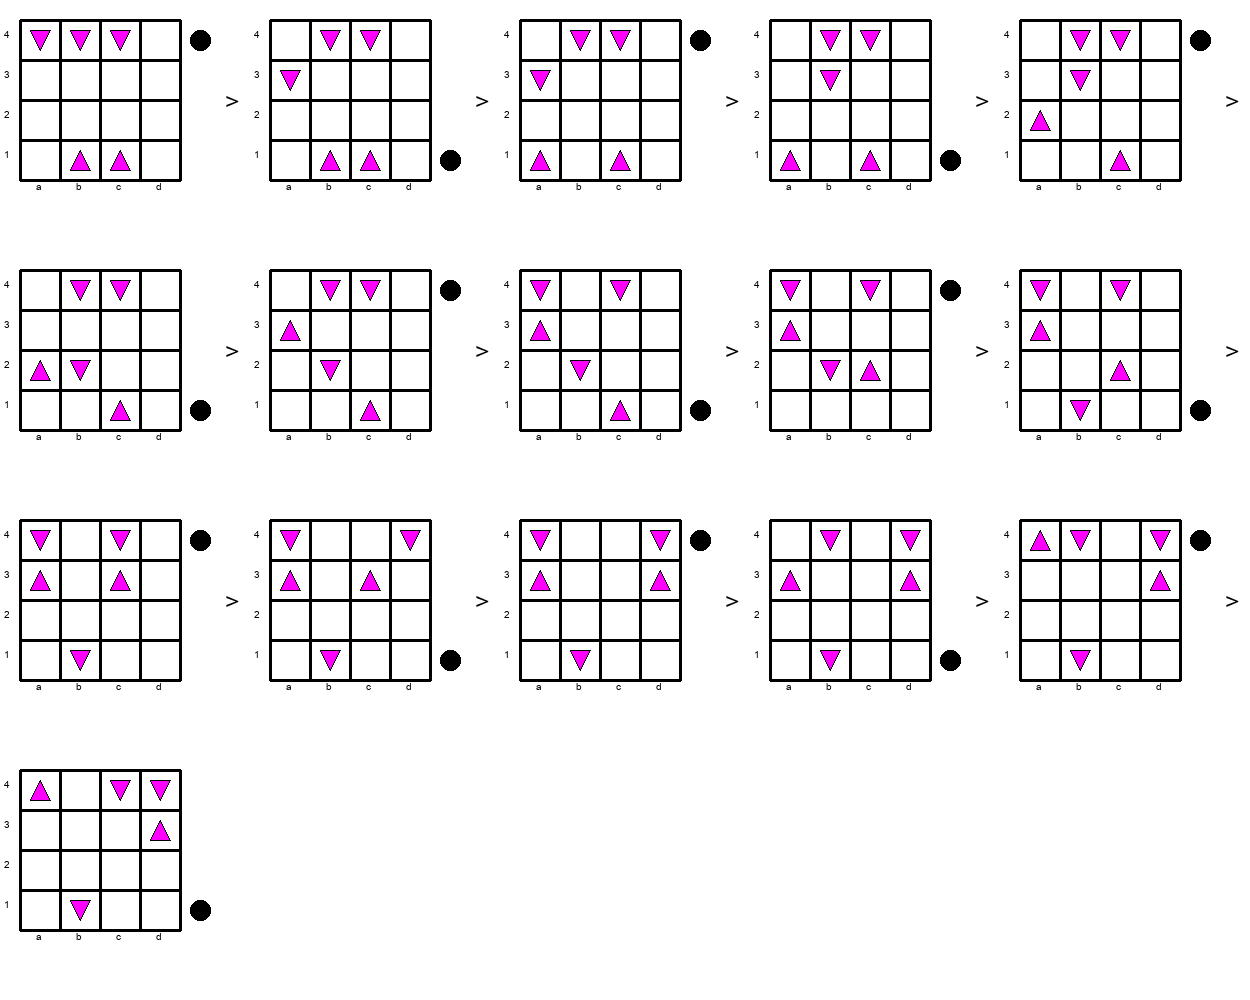

In [ ]:
# 初期配置は?
s = (-1, ((-3,-3,-3,0),(0,0,0,0),(0,0,0,0),(0,3,3,0)))
print(results_rm05_br2bbr[0][s])
states = one_seq(s, results_rm05_br2bbr)
print(states)
showstates(states)

以上の結果より，bbr対brのナッシュ均衡解が存在するとしたら，3駒側からみて，1/3以上1/2 以下であることが言える．


# Rbr vs br で利得0を目指す．
Rbr と br とする．
自分の(手番のプレイヤのではなく)勝ち局面は
- 自分の手番
 - 自分の駒が脱出ポイントにいる．
 - 相手の駒の色を決めつけた時にどちらでも勝ち

負け局面は
- 相手の手番
 - 相手の紫駒が脱出ポイントにいる．
 - 相手の駒が自分の赤駒を取った時に負け
 - 相手の駒が自分の紫駒を取ったった時に確定した赤青駒の局面が自分の勝ちではない．

In [ ]:
# is_final_draw_Rbr2br
# return value
# 1 : the state is final and player 1 can draw
# -1 : the state is final and player 1 can't draw
# 0 : the state is not final
from collections import Counter
from itertools import permutations
def is_final_draw_Rbr2br(state, results_det, results_draw_br2br):
    turn, board = state
    H, W = len(state[1]), len(state[1][0])
    mypieces, oppieces = get_pieces(board)
    pcounts = Counter(board[y][x] for y in range(H) for x in range(W))
    assert len(mypieces) == 3 and len(oppieces) == 2
    assert pcounts[3] == 2 and pcounts[2] == 1 and pcounts[-3] == 2
    myred = [p for p in mypieces if board[p[1]][p[0]] == 2]
    mypurple = [p for p in mypieces if board[p[1]][p[0]] == 3]
    if turn == 1:
        if board[0][0] == 3 or board[0][W - 1] == 3: # can escape
            return 1
        for myps in permutations(mypurple):
            for opps in permutations(oppieces):
                newboard = [list(row) for row in board]
                newboard[myps[0][1]][myps[0][0]] = 1
                newboard[myps[1][1]][myps[1][0]] = 2
                newboard[opps[0][1]][opps[0][0]] = -1
                newboard[opps[1][1]][opps[1][0]] = -2
                newstate =  (turn, tuple(tuple(row) for row in newboard))
                if results_det[0][newstate] != 1:
                    return 0
            return 1
        return 0
    else:
        if board[H - 1][0] == -3 or board[H - 1][W - 1]== -3: # 相手番で脱出できるようなら負け
            return -1
        # capture red
        for opp in nextpos(myred[0], H, W):
            if board[opp[1]][opp[0]] != -3:
                continue
            newboard = [list(row) for row in board]
            newboard[myred[0][1]][myred[0][0]] = -3
            newboard[opp[1]][opp[0]] = 0
            newstate =  (-turn, tuple(tuple(row) for row in newboard))
            if results_draw_br2br[0][newstate] == -1:
                return -1
        # capture purple
        for i, myp in enumerate(mypurple):
            for opp in nextpos(myp, H, W):
                if board[opp[1]][opp[0]] != -3:
                    continue
                newboard = [list(row) for row in board]
                newboard[myp[1]][myp[0]] = -3
                newboard[opp[1]][opp[0]] = 0
                myo = mypurple[1 - i]
                newboard[myp[1]][myp[0]] = 1 # blue
                newstate =  (-turn, tuple(tuple(row) for row in newboard))
                if results_det[0][newstate] != 1:
                    return -1
        return 0

In [ ]:
all_Rbr2br = states_from_combination(4, 4, mycolorscomb=((3, 3, 2),), opcolorscomb=((-3, -3),))
results_draw_Rbr2br = rga(all_Rbr2br, {s: is_final_draw_Rbr2br(s, results_det, results_draw_br2br) for s in all_Rbr2br})
save_result(results_draw_Rbr2br, f'{dir}/results_drwa_Rbr2br.pickle')

0
[(1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 2, 0, 0), (0, 3, 3, 0))), (-1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 0, 2, 0), (0, 3, 3, 0))), (1, ((0, 0, -3, 0), (0, -3, 0, 0), (0, 0, 2, 0), (0, 3, 3, 0))), (-1, ((0, 0, -3, 0), (0, -3, 2, 0), (0, 0, 0, 0), (0, 3, 3, 0))), (1, ((0, 0, 0, -3), (0, -3, 2, 0), (0, 0, 0, 0), (0, 3, 3, 0))), (-1, ((0, 0, 0, -3), (0, -3, 0, 2), (0, 0, 0, 0), (0, 3, 3, 0))), (1, ((0, 0, 0, -3), (-3, 0, 0, 2), (0, 0, 0, 0), (0, 3, 3, 0))), (-1, ((0, 0, 0, -3), (-3, 0, 0, 2), (0, 0, 3, 0), (0, 3, 0, 0))), (1, ((0, 0, 0, -3), (0, 0, 0, 2), (-3, 0, 3, 0), (0, 3, 0, 0))), (-1, ((0, 0, 0, -3), (0, 0, 0, 2), (-3, 0, 0, 3), (0, 3, 0, 0))), (1, ((0, 0, -3, 0), (0, 0, 0, 2), (-3, 0, 0, 3), (0, 3, 0, 0))), (-1, ((0, 0, -3, 0), (0, 0, 2, 0), (-3, 0, 0, 3), (0, 3, 0, 0))), (1, ((0, 0, 0, -3), (0, 0, 2, 0), (-3, 0, 0, 3), (0, 3, 0, 0)))]


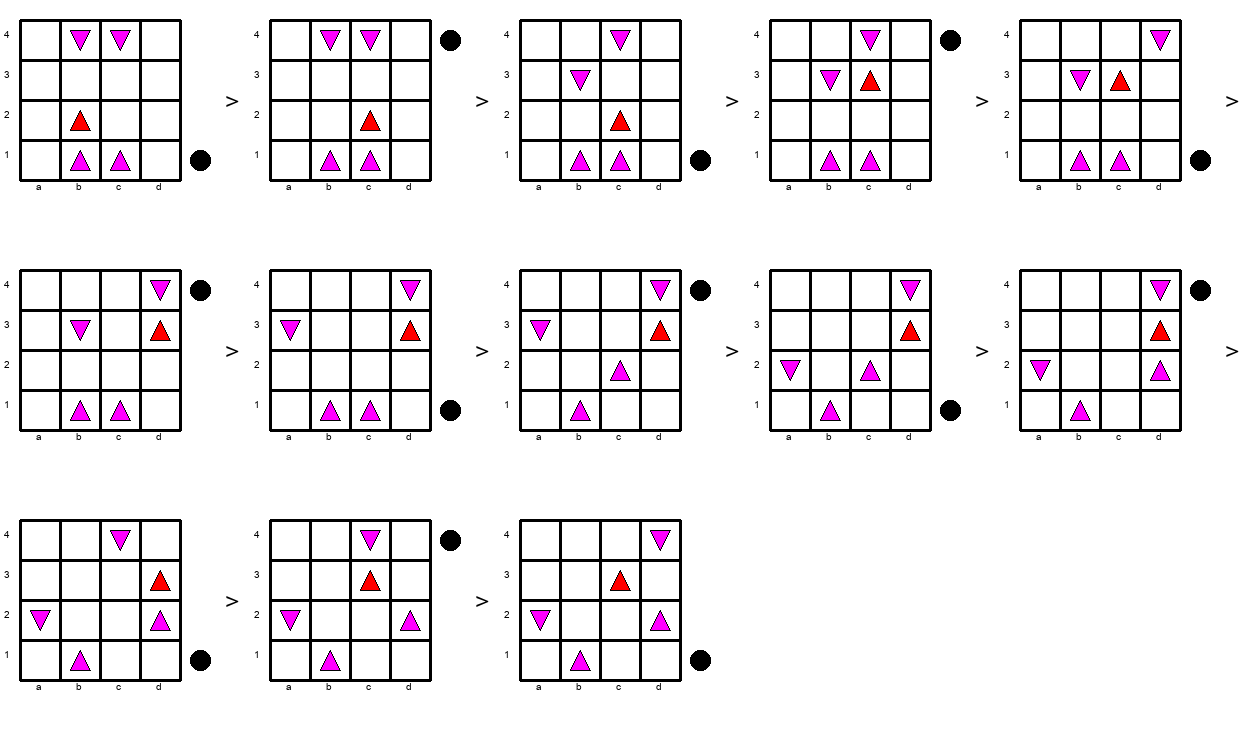

In [ ]:
s = (1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 2, 0, 0), (0, 3, 3, 0)))
print(results_draw_Rbr2br[0][s])
states = one_seq(s, results_draw_Rbr2br)
print(states)
showstates(states)

この結果によると，引き分けにできるようだ．
手番を変えてみる．

0
[(-1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 2, 0, 0), (0, 3, 3, 0))), (1, ((0, 0, -3, 0), (0, -3, 0, 0), (0, 2, 0, 0), (0, 3, 3, 0))), (-1, ((0, 0, -3, 0), (0, -3, 0, 0), (0, 2, 0, 0), (3, 0, 3, 0))), (1, ((0, 0, 0, -3), (0, -3, 0, 0), (0, 2, 0, 0), (3, 0, 3, 0))), (-1, ((0, 0, 0, -3), (0, -3, 0, 0), (0, 2, 3, 0), (3, 0, 0, 0))), (1, ((0, 0, 0, -3), (-3, 0, 0, 0), (0, 2, 3, 0), (3, 0, 0, 0))), (-1, ((0, 0, 0, -3), (-3, 0, 0, 0), (2, 0, 3, 0), (3, 0, 0, 0))), (1, ((0, 0, 0, 0), (-3, 0, 0, -3), (2, 0, 3, 0), (3, 0, 0, 0))), (-1, ((0, 0, 0, 0), (-3, 0, 0, -3), (2, 0, 3, 0), (0, 3, 0, 0))), (1, ((0, 0, 0, -3), (-3, 0, 0, 0), (2, 0, 3, 0), (0, 3, 0, 0))), (-1, ((0, 0, 0, -3), (-3, 0, 0, 0), (2, 0, 0, 3), (0, 3, 0, 0))), (1, ((0, 0, -3, 0), (-3, 0, 0, 0), (2, 0, 0, 3), (0, 3, 0, 0))), (-1, ((0, 0, -3, 0), (-3, 0, 0, 0), (2, 0, 0, 3), (3, 0, 0, 0))), (1, ((0, 0, 0, -3), (-3, 0, 0, 0), (2, 0, 0, 3), (3, 0, 0, 0))), (-1, ((0, 0, 0, -3), (-3, 0, 0, 0), (2, 0, 0, 0), (3, 0, 0, 3))), (1, ((0, 0, 0,

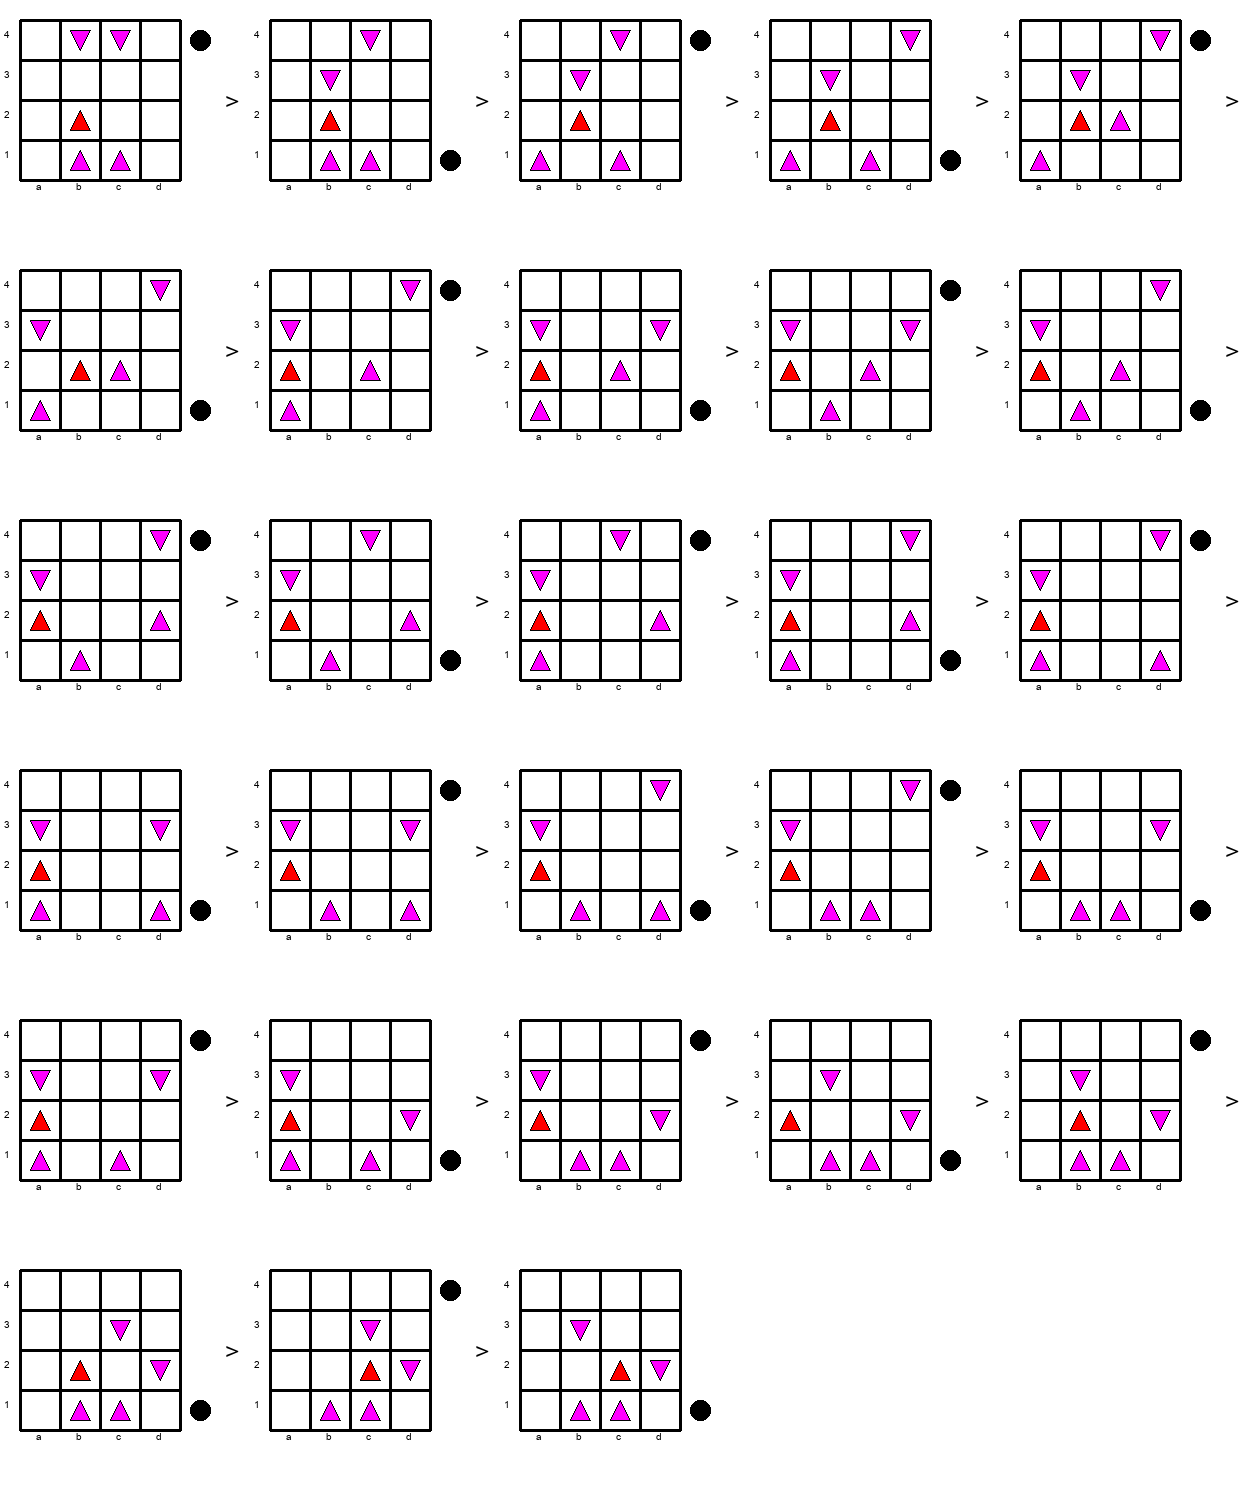

In [ ]:
s = (-1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 2, 0, 0), (0, 3, 3, 0)))
print(results_draw_Rbr2br[0][s])
states = one_seq(s, results_draw_Rbr2br)
print(states)
showstates(states)

0
[(1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 2, 3, 3))), (-1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 2, 0, 0), (0, 0, 3, 3))), (1, ((0, 0, -3, 0), (0, -3, 0, 0), (0, 2, 0, 0), (0, 0, 3, 3))), (-1, ((0, 0, -3, 0), (0, -3, 0, 0), (0, 0, 2, 0), (0, 0, 3, 3))), (1, ((0, 0, 0, -3), (0, -3, 0, 0), (0, 0, 2, 0), (0, 0, 3, 3))), (-1, ((0, 0, 0, -3), (0, -3, 0, 0), (0, 0, 0, 2), (0, 0, 3, 3))), (1, ((0, 0, 0, -3), (0, 0, 0, 0), (0, -3, 0, 2), (0, 0, 3, 3))), (-1, ((0, 0, 0, -3), (0, 0, 0, 2), (0, -3, 0, 0), (0, 0, 3, 3))), (1, ((0, 0, 0, -3), (0, 0, 0, 2), (-3, 0, 0, 0), (0, 0, 3, 3))), (-1, ((0, 0, 0, -3), (0, 0, 0, 2), (-3, 0, 0, 0), (0, 3, 0, 3))), (1, ((0, 0, -3, 0), (0, 0, 0, 2), (-3, 0, 0, 0), (0, 3, 0, 3))), (-1, ((0, 0, -3, 0), (0, 0, 2, 0), (-3, 0, 0, 0), (0, 3, 0, 3))), (1, ((0, 0, 0, -3), (0, 0, 2, 0), (-3, 0, 0, 0), (0, 3, 0, 3)))]


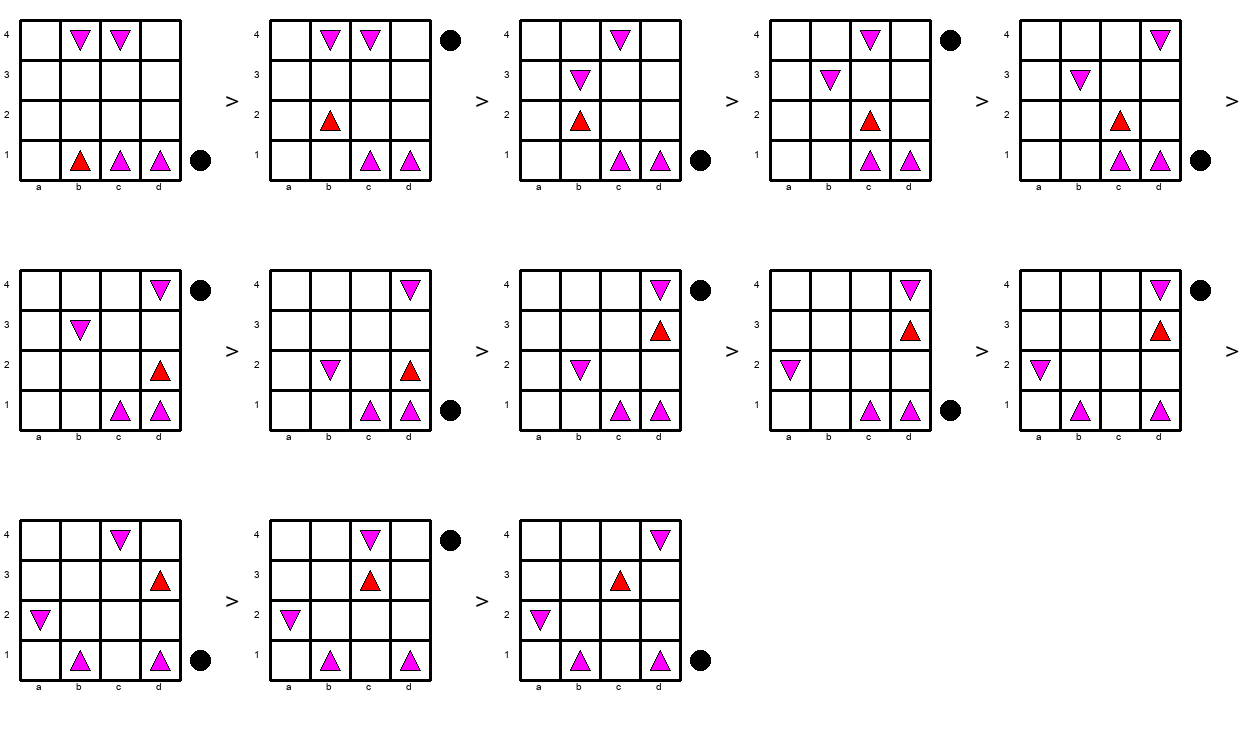

In [ ]:
s = (1, ((0, -3, -3, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 2, 3, 3)))
print(results_draw_Rbr2br[0][s])
states = one_seq(s, results_draw_Rbr2br)
print(states)
showstates(states)